In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('C:\\Users\\praba\\Documents\\GitHub\\research-project-on-physics-informed-machine-learning-on-transcriptomics-data\\arabido_example_genes.csv')

In [3]:
df

Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38471   0.505000   0.505000   0.505000
5  AT2G38472   0.900000   0.500000   0.000000
6  AT2G38473   0.700000   0.700000   0.700000
7  AT2G38474   0.000000   0.500000   0.000000
8  AT2G38470   0.906000   0.906000   0.906000

# Neural ode +Inverse Pinn
## Create a class that defines the ODE function. This class should inherit from nn.Module and implement the forward method, which takes the current time t and state y as inputs and returns the derivative of the state.

        t_tensor = torch.ones_like(y) * t  # replicate t to match the shape of y
        dy_dt = self.net(t_tensor)
        return dy_dt

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

##############################################################################
# Data Setup (Row-wise: Each row is a gene; columns are Day1, Day2, Day4)
##############################################################################

# # Example dataset
# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
#     "Day1":  [-0.44796,    1.77836,     0.0,         0.05537],
#     "Day2":  [-0.56015,    0.0,         1.17515,     0.09843],
#     "Day4":  [-5.09196,    0.0,         0.0,        -0.10176],
# }
# df = pd.DataFrame(data)
# print("Original Data:")
# print(df)

# # Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# # gene_data shape: (num_genes, num_time_points)
# gene_data = df[["Day1", "Day2", "Day4"]].values
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values


# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Neural ODE Model for Each Gene
##############################################################################

class GeneSpecificODE(nn.Module):
    """
    A small neural network that models dY/dt for a single gene as a function of time.
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),  # Input: time (scalar)
            nn.Tanh(),
            nn.Linear(16, 1)   # Output: derivative dY/dt
        )

    def forward(self, t, y):
        # Here we use only time t as input (y can be concatenated if needed)
        t_tensor = torch.ones_like(y) * t  # replicate t to match the shape of y
        dy_dt = self.net(t_tensor)
        return dy_dt

# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneSpecificODE() for _ in range(num_genes)])

##############################################################################
# Inverse PINN Loss Function (Data loss + Physics loss)
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]

    for i in range(n_genes):
        y_observed = gene_data[i]   # shape: (num_time_points,)

        # Use the first time point as the initial condition
        y0 = y_observed[0].unsqueeze(0)  # shape: (1,)

        # Solve the ODE for gene i over the time points
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)

        # Data loss: Mean Squared Error between predictions and observed data
        data_loss = torch.mean((preds - y_observed)**2)

        # Physics loss: Ensure that the derivative from the prediction matches the network output
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        # Evaluate the derivative using the ODE network for each time point
        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)

        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 300

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")




Epoch    0 | Total Loss: 1.3957 | Data Loss: 1.3517 | Physics Loss: 0.4396
Epoch  100 | Total Loss: 0.1028 | Data Loss: 0.0723 | Physics Loss: 0.3053
Epoch  200 | Total Loss: 0.0784 | Data Loss: 0.0542 | Physics Loss: 0.2426


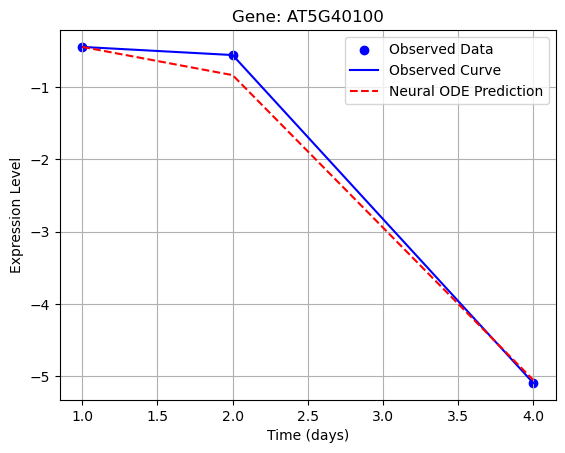

ODE Parameters for Gene AT5G40100:
  net.0.weight: tensor([[ 0.3551],
        [ 0.3265],
        [-0.2931],
        [-0.8638],
        [-0.1333],
        [-0.6440],
        [-0.2286],
        [ 0.2916],
        [-0.2756],
        [ 0.1211],
        [-0.5239],
        [ 0.3775],
        [-0.3773],
        [-0.3814],
        [-0.6204],
        [ 0.2844]])
  net.0.bias: tensor([-0.2191,  0.3779, -0.1474, -0.3722, -0.2642,  1.5068, -0.2238,  0.6559,
         0.7495,  0.4741,  1.0383, -0.3559,  0.4206,  0.2048,  1.4383,  0.3435])
  net.2.weight: tensor([[-0.2210, -0.2697,  0.1316, -0.0728,  0.2993,  0.3859,  0.1546, -0.3265,
          0.1176,  0.0665,  0.4639, -0.2479,  0.3070,  0.3090,  0.4621, -0.1389]])
  net.2.bias: tensor([0.0416])
Formatted ODE Equation: dAT5G40100/dt = -0.2210 * tanh(0.3551 * t + -0.2191) + 0.0416 



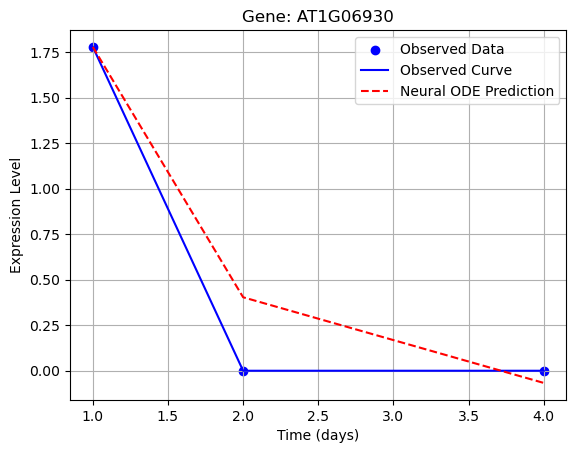

ODE Parameters for Gene AT1G06930:
  net.0.weight: tensor([[-0.5181],
        [-0.2724],
        [ 0.3469],
        [ 1.0936],
        [ 0.9430],
        [ 2.1385],
        [-1.5308],
        [ 0.4654],
        [-0.3136],
        [-0.2071],
        [-0.5047],
        [-2.1643],
        [ 0.7336],
        [-2.9115],
        [ 1.9618],
        [-0.6686]])
  net.0.bias: tensor([ 1.0664, -0.1147, -0.3652,  1.2798,  1.3676, -2.4321,  1.5634, -0.8415,
         0.2756, -0.6490,  0.2825,  2.4343, -0.3260,  3.3756, -2.1966,  1.5390])
  net.2.weight: tensor([[-0.5491, -0.1690,  0.2231,  0.2872,  0.0983, -0.5534,  0.2638,  0.5301,
         -0.4630,  0.1106, -0.0031,  0.4874, -0.1803,  0.4267, -0.3662, -1.2943]])
  net.2.bias: tensor([0.2214])
Formatted ODE Equation: dAT1G06930/dt = -0.5491 * tanh(-0.5181 * t + 1.0664) + 0.2214 



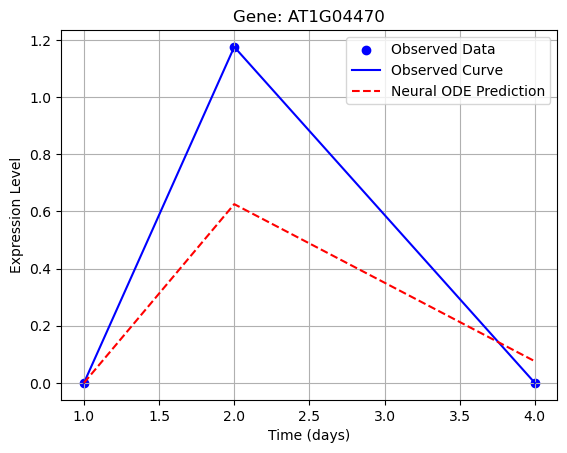

ODE Parameters for Gene AT1G04470:
  net.0.weight: tensor([[ 0.0833],
        [-0.2714],
        [ 0.2504],
        [-1.9961],
        [-0.0342],
        [ 1.0149],
        [ 0.1847],
        [ 1.0992],
        [-0.2199],
        [-1.2489],
        [-0.3649],
        [-0.0851],
        [-0.0966],
        [ 0.6720],
        [-0.1305],
        [ 0.4947]])
  net.0.bias: tensor([ 0.9173,  0.3422, -0.2692,  2.2225,  0.5142, -0.8120,  0.7425, -0.9508,
         0.1022,  1.1855, -0.5208, -0.3207, -0.7995, -1.7120, -0.8641, -1.2234])
  net.2.weight: tensor([[-0.2015,  0.2780, -0.0552, -0.2997, -0.1045,  0.1946, -0.1528,  0.2303,
          0.1648, -0.3496, -0.0192,  0.1198,  0.1603, -0.9969,  0.2029, -0.4175]])
  net.2.bias: tensor([-0.0544])
Formatted ODE Equation: dAT1G04470/dt = -0.2015 * tanh(0.0833 * t + 0.9173) + -0.0544 



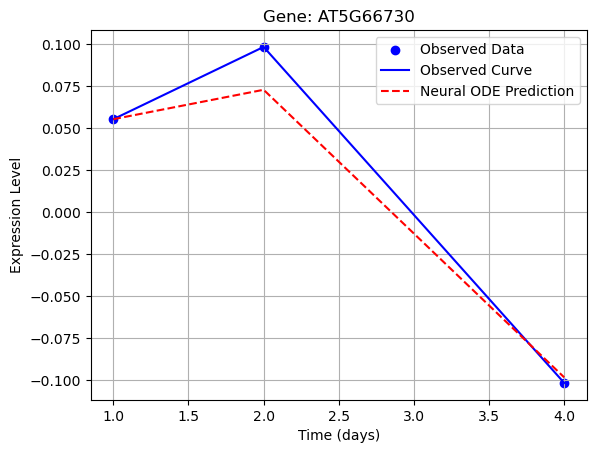

ODE Parameters for Gene AT5G66730:
  net.0.weight: tensor([[-0.6357],
        [-0.0455],
        [-0.6291],
        [ 0.0123],
        [ 0.1705],
        [ 0.1959],
        [-0.1719],
        [-0.0902],
        [ 0.2877],
        [-0.3960],
        [-0.6375],
        [ 0.3910],
        [ 0.2198],
        [-0.6008],
        [ 0.3702],
        [ 0.1978]])
  net.0.bias: tensor([-0.1863, -0.5515,  0.6031,  0.0179, -0.0546,  0.9512, -0.3068, -0.3300,
         0.7746,  0.2589, -0.3934, -0.4477, -0.4741,  1.0732, -0.7491,  0.1675])
  net.2.weight: tensor([[-0.2323,  0.1131, -0.1689,  0.0615, -0.2115,  0.0992,  0.0774, -0.0264,
         -0.1164, -0.0843,  0.1917,  0.0952, -0.2404,  0.0982, -0.2109,  0.2183]])
  net.2.bias: tensor([-0.1389])
Formatted ODE Equation: dAT5G66730/dt = -0.2323 * tanh(-0.6357 * t + -0.1863) + -0.1389 



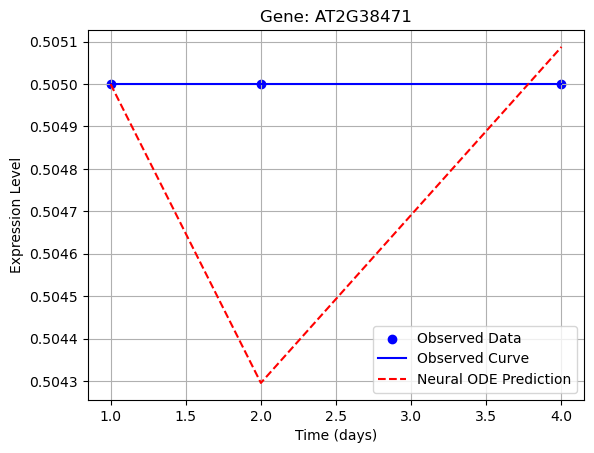

ODE Parameters for Gene AT2G38471:
  net.0.weight: tensor([[ 0.1685],
        [ 0.0683],
        [-0.0535],
        [-0.7065],
        [-0.0609],
        [-0.8524],
        [-0.3907],
        [ 0.0840],
        [-0.4375],
        [-0.5987],
        [ 0.1012],
        [-0.1044],
        [-0.3324],
        [ 0.6681],
        [ 0.1351],
        [-0.3341]])
  net.0.bias: tensor([ 0.1093,  0.4410,  0.6895,  0.6214,  0.2728, -0.5925,  0.7516,  0.1277,
         0.8682, -0.2646,  0.3113, -0.9431, -0.6497,  0.1905, -0.2427,  0.8794])
  net.2.weight: tensor([[ 0.2359, -0.1331, -0.1178, -0.1457, -0.0893,  0.1883,  0.0355,  0.2098,
          0.0811,  0.1622,  0.2032, -0.1103, -0.0679, -0.1599, -0.0937,  0.0788]])
  net.2.bias: tensor([0.1096])
Formatted ODE Equation: dAT2G38471/dt = 0.2359 * tanh(0.1685 * t + 0.1093) + 0.1096 



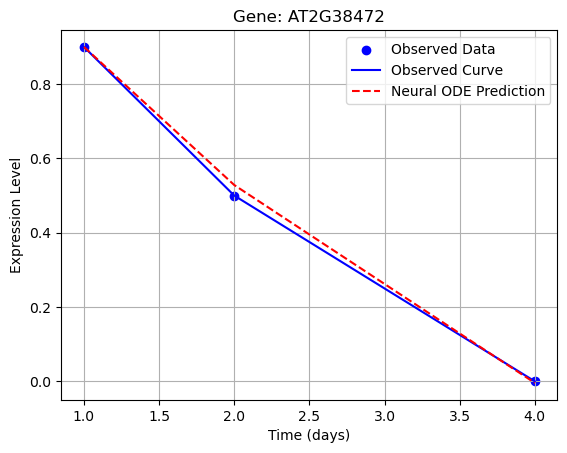

ODE Parameters for Gene AT2G38472:
  net.0.weight: tensor([[ 0.1828],
        [-0.2118],
        [ 0.2180],
        [ 0.2479],
        [ 0.7972],
        [ 1.2462],
        [ 1.4267],
        [-1.4527],
        [-1.6332],
        [-0.6627],
        [-1.1769],
        [ 1.3532],
        [-0.2814],
        [ 0.3588],
        [-0.2355],
        [-0.3556]])
  net.0.bias: tensor([ 0.3226,  0.0017,  0.4416,  0.2843, -0.1404,  1.0207, -1.3741,  1.3963,
         1.6548, -0.1196,  0.9418,  1.1874,  0.3941, -0.7562, -0.9941, -0.8151])
  net.2.weight: tensor([[ 0.0753, -0.1266, -0.1474,  0.2224, -0.1026,  0.2784, -0.2965,  0.3078,
          0.1458,  0.1780,  0.2021,  0.1531, -0.6113,  0.4353, -0.1575,  0.1815]])
  net.2.bias: tensor([-0.0250])
Formatted ODE Equation: dAT2G38472/dt = 0.0753 * tanh(0.1828 * t + 0.3226) + -0.0250 



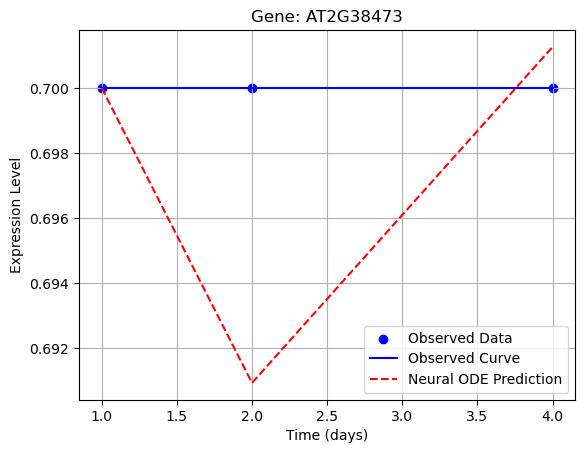

ODE Parameters for Gene AT2G38473:
  net.0.weight: tensor([[-0.1334],
        [ 0.8512],
        [-0.8532],
        [ 0.8465],
        [-0.1891],
        [-0.8232],
        [ 0.7442],
        [ 0.7715],
        [ 0.3121],
        [ 0.7925],
        [ 0.0434],
        [-0.3999],
        [-0.9236],
        [ 0.1669],
        [-0.1029],
        [-0.4252]])
  net.0.bias: tensor([-0.2034, -0.0774,  0.5687,  0.9809,  0.1905, -0.2131, -0.8301, -0.5155,
        -0.6872, -0.0183,  0.8956,  0.8354,  0.5106,  0.1748, -0.0862,  0.2395])
  net.2.weight: tensor([[ 0.1674, -0.1388,  0.1064,  0.2672,  0.0157,  0.1924,  0.0580, -0.1769,
          0.0184, -0.1822,  0.2106,  0.0087, -0.2635,  0.0502,  0.1028, -0.2640]])
  net.2.bias: tensor([-0.0569])
Formatted ODE Equation: dAT2G38473/dt = 0.1674 * tanh(-0.1334 * t + -0.2034) + -0.0569 



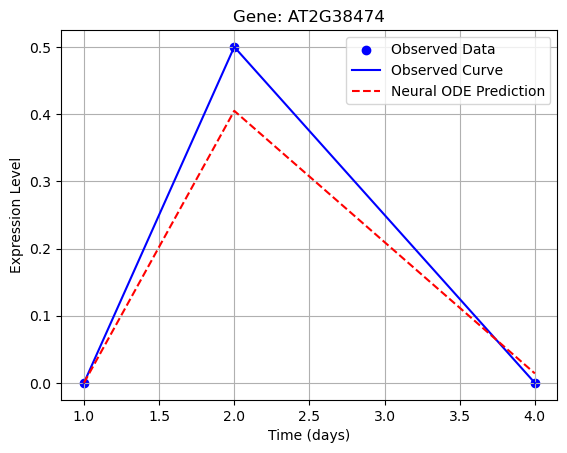

ODE Parameters for Gene AT2G38474:
  net.0.weight: tensor([[ 1.5219],
        [-1.1345],
        [-0.7835],
        [-0.7510],
        [ 0.2651],
        [ 0.0063],
        [-0.6410],
        [ 0.7544],
        [ 0.4477],
        [ 0.2734],
        [-0.4368],
        [ 0.3523],
        [-0.2319],
        [-0.4171],
        [-2.5380],
        [ 0.3129]])
  net.0.bias: tensor([-1.5603,  0.9401,  0.2923, -1.4714, -0.2624,  1.0076, -0.0286,  1.8915,
         0.3065, -0.2216,  0.9431, -0.6715, -0.2943,  0.8934,  2.8882, -0.4914])
  net.2.weight: tensor([[ 0.4270, -0.2417, -0.0577,  0.2473, -0.2742, -0.2165, -0.1074, -0.0918,
          0.1567, -0.1748,  1.0818, -0.2332,  0.0384,  0.1414, -0.3278, -0.1273]])
  net.2.bias: tensor([-0.1784])
Formatted ODE Equation: dAT2G38474/dt = 0.4270 * tanh(1.5219 * t + -1.5603) + -0.1784 



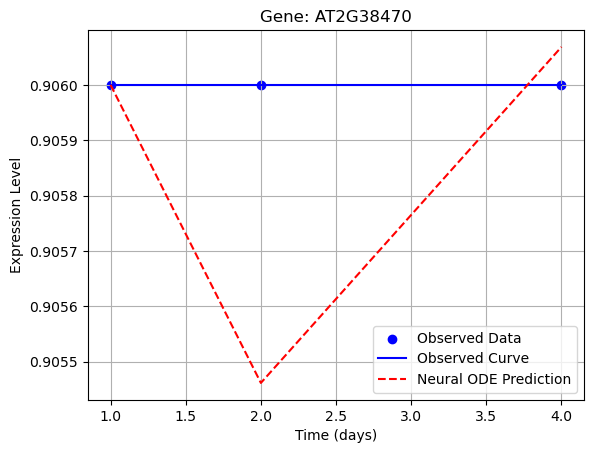

ODE Parameters for Gene AT2G38470:
  net.0.weight: tensor([[-0.8111],
        [ 0.8868],
        [ 0.9329],
        [-0.6131],
        [ 0.3790],
        [ 0.1715],
        [ 0.8527],
        [-0.4756],
        [ 0.3512],
        [ 0.3104],
        [ 0.4903],
        [ 0.3813],
        [ 0.2282],
        [-0.5463],
        [-0.9102],
        [-0.7235]])
  net.0.bias: tensor([-0.1077, -0.4074,  0.4716, -0.5996,  0.6620, -0.6579, -0.5340, -0.9853,
        -0.1204, -0.2245,  0.8916, -0.8564, -0.5151, -0.8157,  0.5198, -0.5289])
  net.2.weight: tensor([[ 0.1745, -0.0696, -0.1257, -0.2554,  0.0510, -0.1319, -0.0390,  0.0806,
         -0.1672,  0.1516, -0.0322,  0.0066,  0.0712,  0.1762, -0.1979,  0.0324]])
  net.2.bias: tensor([0.2252])
Formatted ODE Equation: dAT2G38470/dt = 0.1745 * tanh(-0.8111 * t + -0.1077) + 0.2252 



In [7]:
##############################################################################
# Plotting Predictions and Printing ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        # Use the initial condition from Day1 for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)

        # Solve the ODE to get predictions over the time points
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data vs. Neural ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print the learned ODE parameters (weights and biases)
        print(f"ODE Parameters for Gene {gene_id}:")
        for name, param in ode_models[i].named_parameters():
            if param.requires_grad:
                print(f"  {name}: {param.data}")

        # Optionally, display a formatted ODE equation (using only the first neuron in each layer)
        W1 = ode_models[i].net[0].weight.detach().numpy()  # shape (16, 1)
        b1 = ode_models[i].net[0].bias.detach().numpy()      # shape (16,)
        W2 = ode_models[i].net[2].weight.detach().numpy()     # shape (1, 16)
        b2 = ode_models[i].net[2].bias.detach().numpy()       # shape (1,)

        # For a simplified representation, we take the first hidden neuron:
        equation = f"d{gene_id}/dt = {W2[0,0]:.4f} * tanh({W1[0,0]:.4f} * t + {b1[0]:.4f}) + {b2[0]:.4f}"
        print("Formatted ODE Equation:", equation, "\n")

# Neural ode +Inverse Pinn

## Create a class that defines the ODE function. This class should inherit from nn.Module and implement the forward method, which takes the current time t and state y as inputs and returns the derivative of the state.

      t_tensor = torch.ones_like(y) * t  # shape: (batch_size, 1)
        dy_dt = self.net(t_tensor)
        return dy_dt

Epoch    0 | Total Loss: 2.1918 | Data Loss: 2.1709 | Physics Loss: 0.2096
Epoch  100 | Total Loss: 0.1732 | Data Loss: 0.1230 | Physics Loss: 0.5016
Epoch  200 | Total Loss: 0.1409 | Data Loss: 0.0978 | Physics Loss: 0.4305


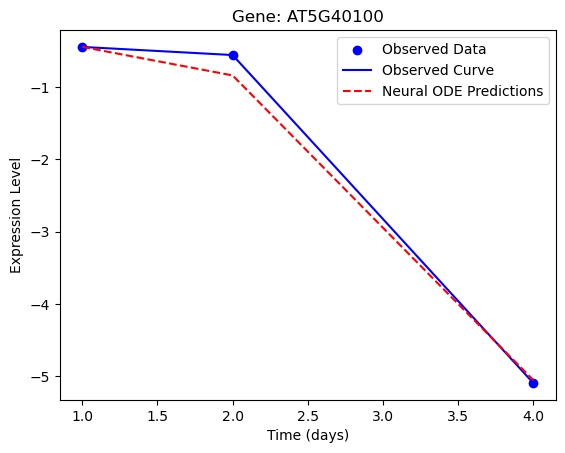

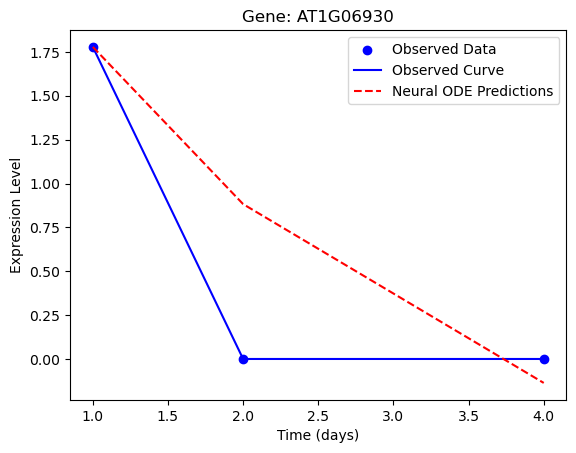

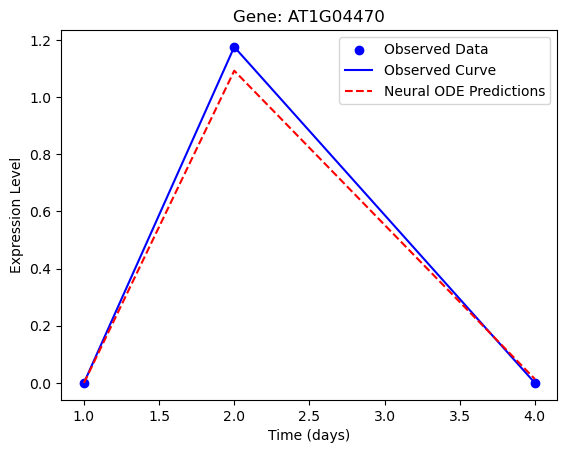

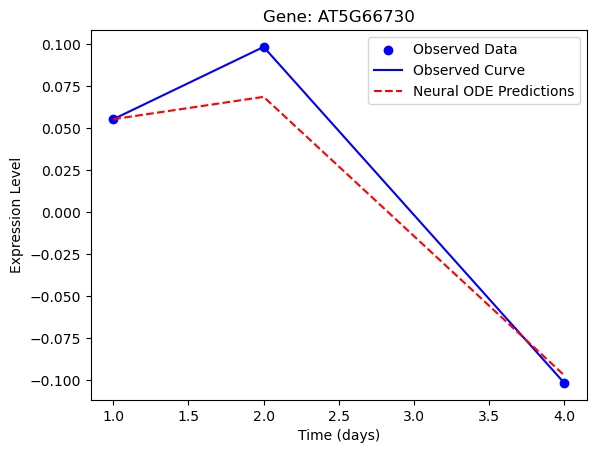

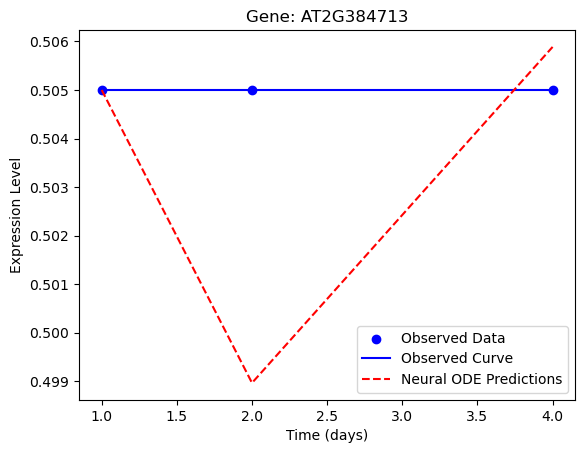


Learned ODE Parameters and Equations:
Gene: AT5G40100
  net.0.weight: tensor([[-1.0489],
        [ 0.4796],
        [-0.5999],
        [-0.3582],
        [ 0.3726],
        [ 0.9236],
        [ 0.3944],
        [ 0.2717],
        [-0.2858],
        [ 0.2779],
        [ 0.4152],
        [-0.3909],
        [-0.2737],
        [ 0.2136],
        [-0.3242],
        [-0.0796]])
  net.0.bias: tensor([-0.4533, -1.0185,  1.4137,  0.3187, -0.6027,  0.6091, -0.7197,  0.3350,
         0.0541, -0.0131, -0.7409,  0.6798, -0.0612,  0.7905,  0.3466,  1.0184])
  net.2.weight: tensor([[-0.1198, -0.3581,  0.4234,  0.4087, -0.2815, -0.0285, -0.4128, -0.0951,
          0.1952, -0.3797, -0.3050,  0.1927,  0.1380, -0.1962,  0.2547, -0.0637]])
  net.2.bias: tensor([-0.2371])
  d(AT5G40100)/dt = -0.1198 * tanh(-1.0489 * t + -0.4533) + -0.2371

Gene: AT1G06930
  net.0.weight: tensor([[ 0.2256],
        [ 0.3134],
        [ 0.4431],
        [ 0.7344],
        [-0.3449],
        [-0.6382],
        [ 0.9003],
   

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

##############################################################################
# Data Setup (Row-wise, Each Column is a Different Day)
##############################################################################

data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G384713"],
    "Day1":  [-0.44796,    1.77836,     0.0,         0.05537,    0.505000   ],
    "Day2":  [-0.56015,    0.0,         1.17515,     0.09843,  0.505000   ],
    "Day4":  [-5.09196,    0.0,         0.0,        -0.10176,  0.505000   ],
}

df = pd.DataFrame(data)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # day1, day2, day4

# gene_data shape: (num_genes, num_time_points)
gene_data = df[["Day1", "Day2", "Day4"]].values  # 4 genes x 3 time points

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Neural ODE Model for Each Gene
##############################################################################

class GeneSpecificODE(nn.Module):
    """
    A small neural network that models dY/dt for a single gene as a function of time, t.
    The forward() method returns the derivative dy/dt given (t, y).
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),  # input: scalar t, output: hidden dimension
            nn.Tanh(),
            nn.Linear(16, 1)   # output: derivative dY/dt
        )

    def forward(self, t, y):
        """
        :param t: current time (scalar)
        :param y: current expression (ignored in this minimal model)
        :return: dy/dt predicted by the neural net
        """
        # For simplicity, we only pass time t into the net (and ignore y).
        # If you want Y dependence, you could concatenate [t, y] as input.
        t_tensor = torch.ones_like(y) * t  # shape: (batch_size, 1)
        dy_dt = self.net(t_tensor)
        return dy_dt


# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneSpecificODE() for _ in range(num_genes)])


##############################################################################
# Training Loss Function
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    """
    :param ode_models: list of neural ODE models, one per gene
    :param time_points: tensor of shape (num_time_points,)
    :param gene_data: tensor of shape (num_genes, num_time_points)
    :param lambda_physics: weight for the physics/ODE consistency term
    :return: (total_loss, data_loss, physics_loss)
    """
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]

    for i in range(n_genes):
        y_observed = gene_data[i]  # e.g. [-0.45, -0.56, -5.09]

        # The first time point is our "initial condition"
        y0 = y_observed[0].unsqueeze(0)  # shape (1,)

        # odeint() requires an initial condition shape (batch_size,) or (batch_size, dim)
        preds = odeint(ode_models[i], y0, time_points).squeeze()

        # 1) Data loss: MSE between predicted and observed
        data_loss = torch.mean((preds - y_observed) ** 2)

        # 2) Physics loss: measure how consistent the predicted derivative is with the ODE network
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]  # shape: (num_time_points,)

        # Evaluate the ODE derivative from the model
        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            # The ODE model expects (t, y) but we're ignoring y in forward()
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)

        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode) ** 2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes

    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss


##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 300

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(
        ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1
    )
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | "
              f"Total Loss: {total_loss.item():.4f} | "
              f"Data Loss: {data_loss.item():.4f} | "
              f"Physics Loss: {physics_loss.item():.4f}")


##############################################################################
# Plotting and Printing Results
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Gene']):
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data and model predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Predictions")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()


##############################################################################
# Print Learned ODE Equations and Parameters
##############################################################################

print("\nLearned ODE Parameters and Equations:")
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models[i]
    print(f"Gene: {gene_id}")

    # Print each parameter (weights and biases)
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"  {name}: {param.data}")

    # For demonstration, we assume the ODE is:
    # dY/dt = W2 * tanh(W1 * t + b1) + b2
    # (since we only pass t to the net, ignoring Y)
    W1 = model.net[0].weight.detach().numpy().flatten()
    b1 = model.net[0].bias.detach().numpy().flatten()
    W2 = model.net[2].weight.detach().numpy().flatten()
    b2 = model.net[2].bias.detach().numpy().flatten()

    eq_str = f"d({gene_id})/dt = {W2[0]:.4f} * tanh({W1[0]:.4f} * t + {b1[0]:.4f}) + {b2[0]:.4f}"
    print("  " + eq_str + "\n")


# Neural ode +Inverse Pinn

## LSTM 

        t_tensor = torch.ones_like(y) * t  # shape (batch_size, 1)
        # Concatenate along the last dimension to form (batch_size, 2)
        combined = torch.cat([y, t_tensor], dim=-1)
        # Add sequence dimension: (batch_size, seq_len=1, input_size=2)
        seq_input = combined.unsqueeze(1)
        # Pass through the LSTM. Here, we ignore the hidden state between calls.
        lstm_out, _ = self.lstm(seq_input)
        # Take the output of the last time step and pass it through the linear layer.
        dy_dt = self.linear(lstm_out[:, -1, :])
        return dy_dt

Epoch    0 | Total Loss: 1.8054 | Data Loss: 1.7996 | Physics Loss: 0.0582
Epoch  100 | Total Loss: 0.1206 | Data Loss: 0.0695 | Physics Loss: 0.5102
Epoch  200 | Total Loss: 0.0161 | Data Loss: 0.0122 | Physics Loss: 0.0391


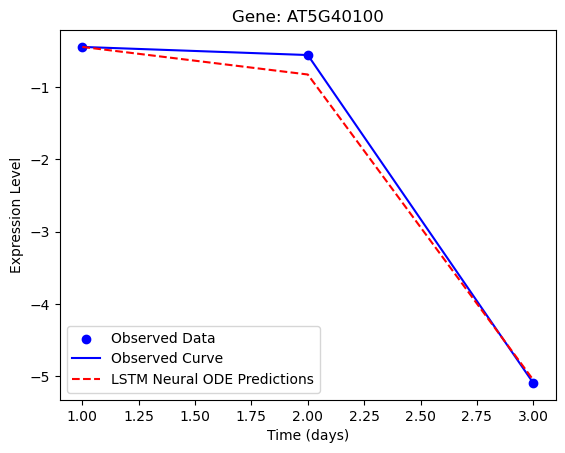

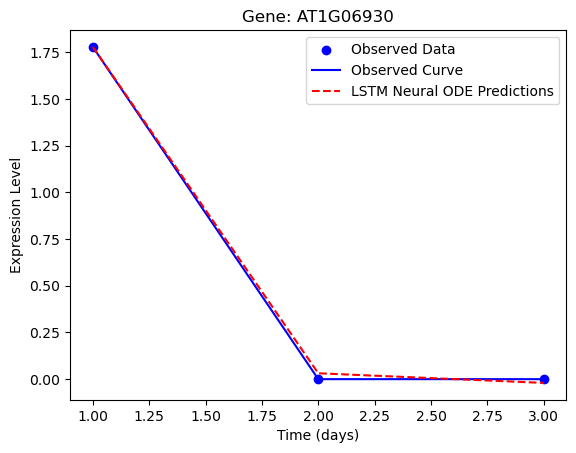

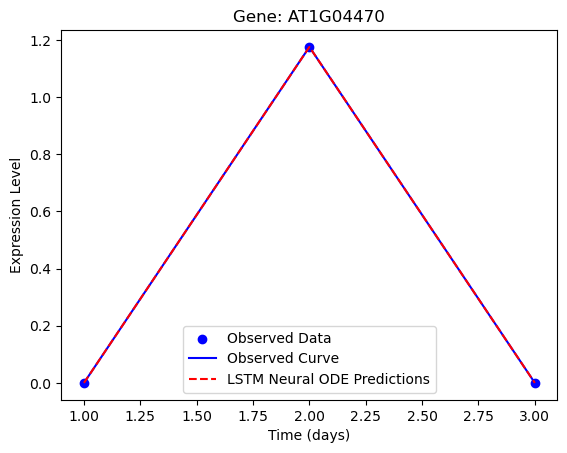

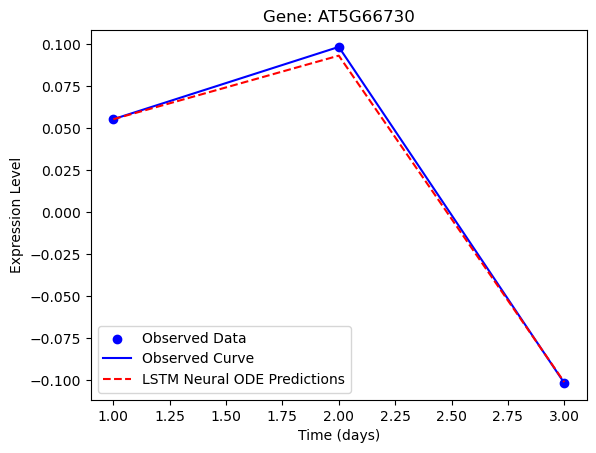

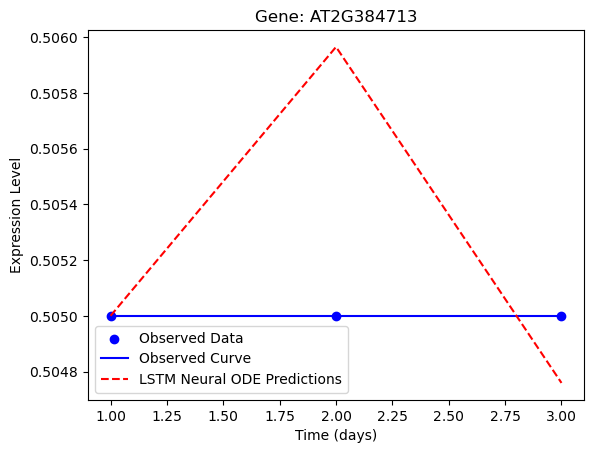


Learned ODE Parameters and Equations (LSTM version):
Gene: AT5G40100
  lstm.weight_ih_l0: tensor([[-0.3180,  0.7567],
        [ 0.3758,  0.0261],
        [-0.5247,  0.3124],
        [-0.6352,  0.4474],
        [-0.3032,  0.4483],
        [-0.5375,  0.7715],
        [-0.5509,  0.5972],
        [-0.5661,  0.4969],
        [-0.4296,  0.6167],
        [-0.7400,  0.6079],
        [-0.3760,  0.3724],
        [ 0.2007, -0.2459],
        [ 0.2803, -0.1681],
        [-0.4317,  0.3302],
        [-0.4969,  0.3406],
        [-0.2781,  0.6120],
        [-0.2260,  0.1543],
        [-0.1166, -0.0539],
        [ 0.1701,  0.0292],
        [-0.1962,  0.1065],
        [-0.0940, -0.0058],
        [-0.0984,  0.0986],
        [-0.0367,  0.0374],
        [-0.0293, -0.0128],
        [ 0.0101,  0.0056],
        [ 0.0311, -0.0739],
        [ 0.0916,  0.1210],
        [ 0.0707,  0.0919],
        [ 0.0889, -0.0027],
        [ 0.0359,  0.0572],
        [-0.0944, -0.0084],
        [ 0.0910,  0.0175],
        [-0.7

In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Example data (each row is one gene, each column is a time point)
# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
#     "Day1":  [-0.44796, 1.77836, 0.0, 0.05537],
#     "Day2":  [-0.56015, 0.0, 1.17515, 0.09843],
#     "Day3":  [-5.09196, 0.0, 0.0, -0.10176]
# }

data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G384713"],
    "Day1":  [-0.44796,    1.77836,     0.0,         0.05537,    0.505000   ],
    "Day2":  [-0.56015,    0.0,         1.17515,     0.09843,  0.505000   ],
    "Day4":  [-5.09196,    0.0,         0.0,        -0.10176,  0.505000   ],
}

df = pd.DataFrame(data)
time_points = np.array([1.0, 2.0, 3.0], dtype=np.float32)
gene_data = df[["Day1", "Day2", "Day4"]].values  # Shape: (num_genes, num_time_points)

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Neural ODE with LSTM
##############################################################################

class GeneSpecificODE_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        # Here, we use an LSTM to process a 2D input: [y, t]
        # We treat each evaluation as a sequence of length 1.
        self.lstm = nn.LSTM(input_size=2, hidden_size=16, num_layers=1, batch_first=True)
        self.linear = nn.Linear(16, 1)  # Map LSTM output to the derivative

    def forward(self, t, y):
        # y: shape (batch_size, 1) -- current gene expression.
        # We combine y and t into a 2-element feature.
        # Create a tensor for t of the same shape as y.
        t_tensor = torch.ones_like(y) * t  # shape (batch_size, 1)
        # Concatenate along the last dimension to form (batch_size, 2)
        combined = torch.cat([y, t_tensor], dim=-1)
        # Add sequence dimension: (batch_size, seq_len=1, input_size=2)
        seq_input = combined.unsqueeze(1)
        # Pass through the LSTM. Here, we ignore the hidden state between calls.
        lstm_out, _ = self.lstm(seq_input)
        # Take the output of the last time step and pass it through the linear layer.
        dy_dt = self.linear(lstm_out[:, -1, :])
        return dy_dt

# Initialize one LSTM-based ODE model per gene
n_genes = gene_data_tensor.shape[0]
ode_models_lstm = nn.ModuleList([GeneSpecificODE_LSTM() for _ in range(n_genes)])

##############################################################################
# Define the Training Loss Function
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]

    for i in range(n_genes):
        y_true = gene_data[i].unsqueeze(-1)  # shape: (num_time_points, 1)
        y0 = y_true[0].unsqueeze(0)  # initial condition

        preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)
        data_loss = torch.mean((preds - y_true.squeeze()) ** 2)

        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        # Reshape 'p' to (batch_size, 1) before concatenating with 't_tensor'
        dy_dt_ode = torch.stack([ode_models[i](t, p.reshape(-1, 1)) for t, p in zip(time_points, preds)]).squeeze()
        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode) ** 2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models_lstm.parameters(), lr=0.01)
epochs = 300

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(
        ode_models_lstm, time_points_tensor, gene_data_tensor, lambda_physics=0.1
    )
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")

##############################################################################
# Plotting and Printing Results
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df["Gene"]):
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)
        preds = odeint(ode_models_lstm[i], y0, time_points_tensor).squeeze().numpy()
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="LSTM Neural ODE Predictions")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()

##############################################################################
# Print Learned ODE Parameters and Equations for Each Gene
##############################################################################

print("\nLearned ODE Parameters and Equations (LSTM version):")
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models_lstm[i]
    print(f"Gene: {gene_id}")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"  {name}: {param.data}")

    # For the sake of interpretation, we note that the derivative is computed as:
    # dY/dt = Linear( LSTM( [Y, t] ) )
    # Here we extract the linear layer parameters.
    W_linear = model.linear.weight.detach().numpy().flatten()
    b_linear = model.linear.bias.detach().numpy().flatten()
    equation = f"d({gene_id})/dt = LSTM_output*({W_linear[0]:.4f}) + {b_linear[0]:.4f}"
    print("  " + equation + "\n")


# Neural ode +Inverse Pinn

## Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t


Original Data:
         Gene  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0   AT5G40100   -0.44796   -0.56015   -5.09196
1   AT1G06930    1.77836    0.00000    0.00000
2   AT1G04470    0.00000    1.17515    0.00000
3   AT5G66730    0.05537    0.09843   -0.10176
4  AT2G384713    0.50500    0.50500    0.50500
Epoch    0 | Total Loss: 3.7946 | Data Loss: 3.7698 | Physics Loss: 0.2482
Epoch  100 | Total Loss: 0.2664 | Data Loss: 0.1948 | Physics Loss: 0.7163
Epoch  200 | Total Loss: 0.2276 | Data Loss: 0.1586 | Physics Loss: 0.6898
Epoch  300 | Total Loss: 0.1943 | Data Loss: 0.1280 | Physics Loss: 0.6636
Epoch  400 | Total Loss: 0.1678 | Data Loss: 0.1036 | Physics Loss: 0.6418


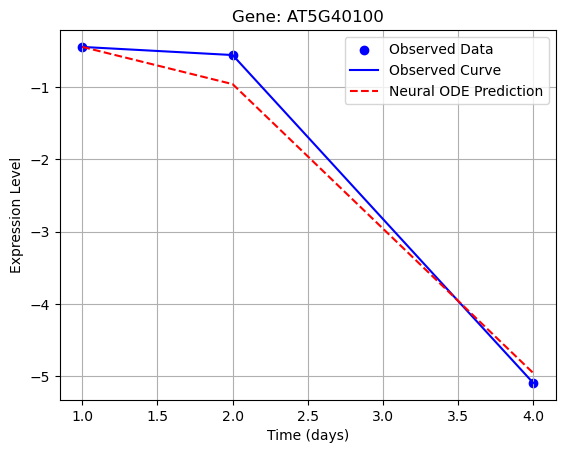

Learned ODE for Gene AT5G40100:
  dy/dt = 0.4125 + 0.4551 * y + -0.4204 * t
Formatted ODE Equation: dy/dt = 0.4125 + 0.4551 * y(t) + -0.4204 * t



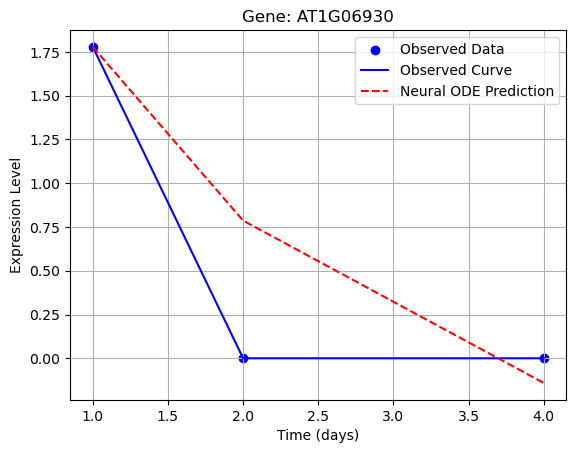

Learned ODE for Gene AT1G06930:
  dy/dt = -0.2511 + -0.5689 * y + -0.0244 * t
Formatted ODE Equation: dy/dt = -0.2511 + -0.5689 * y(t) + -0.0244 * t



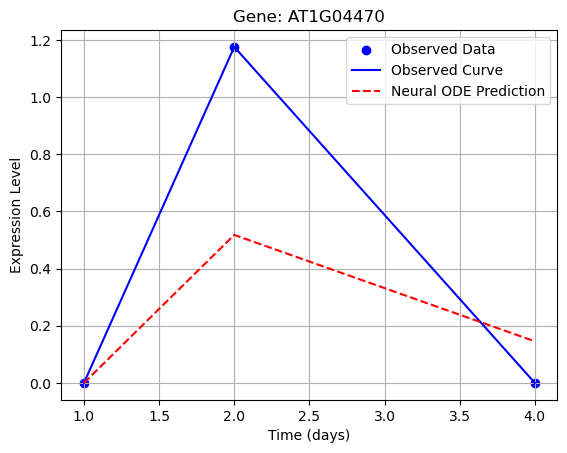

Learned ODE for Gene AT1G04470:
  dy/dt = 1.4061 + -0.7869 * y + -0.4207 * t
Formatted ODE Equation: dy/dt = 1.4061 + -0.7869 * y(t) + -0.4207 * t



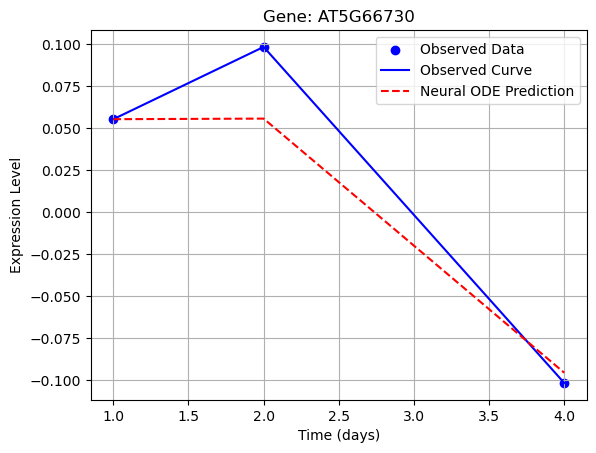

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0803 + -0.0320 * y + -0.0521 * t
Formatted ODE Equation: dy/dt = 0.0803 + -0.0320 * y(t) + -0.0521 * t



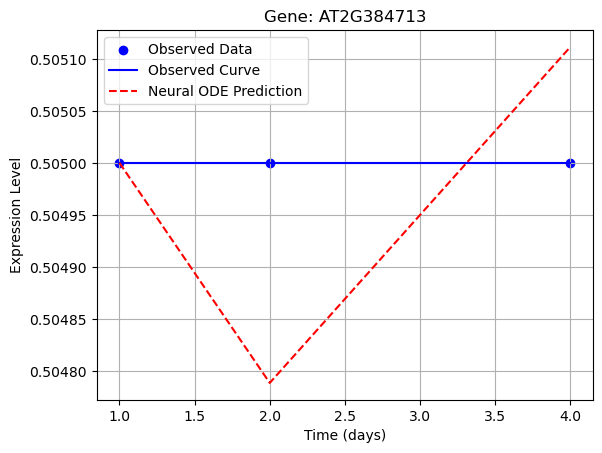

Learned ODE for Gene AT2G384713:
  dy/dt = 0.0110 + -0.0230 * y + 0.0002 * t
Formatted ODE Equation: dy/dt = 0.0110 + -0.0230 * y(t) + 0.0002 * t



In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

##############################################################################
# Data Setup (Row-wise: Each row is a gene; columns are Day1, Day2, Day4)
##############################################################################

# Example dataset (here using gene names and expression values)
# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
#     "Hpa-NO_1d": [-0.44796, 1.77836, 0.0, 0.05537],
#     "Hpa-NO_2d": [-0.56015, 0.0, 1.17515, 0.09843],
#     "Hpa-NO_4d": [-5.09196, 0.0, 0.0, -0.10176],
# }


data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G384713"],
    "Hpa-NO_1d":  [-0.44796,    1.77836,     0.0,         0.05537,    0.505000   ],
    "Hpa-NO_2d":  [-0.56015,    0.0,         1.17515,     0.09843,  0.505000   ],
    "Hpa-NO_4d":  [-5.09196,    0.0,         0.0,        -0.10176,  0.505000   ],
}


df = pd.DataFrame(data)
print("Original Data:")
print(df)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# Extract gene expression data (each row is one gene)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t
##############################################################################

class GeneParametricODE(nn.Module):
    def __init__(self):
        super(GeneParametricODE, self).__init__()
        # Learnable parameters: α, β, and γ
        self.alpha = nn.Parameter(torch.tensor(0.1))
        self.beta = nn.Parameter(torch.tensor(0.1))
        self.gamma = nn.Parameter(torch.tensor(0.1))
    
    def forward(self, t, y):
        # ODE: dy/dt = α + β * y(t) + γ * t
        return self.alpha + self.beta * y + self.gamma * t

# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

##############################################################################
# Inverse PINN Loss Function (Data Loss + Physics Loss)
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]
    
    for i in range(n_genes):
        # Observed expression for gene i (shape: (num_time_points,))
        y_observed = gene_data[i]
        # Use the first time point as the initial condition
        y0 = y_observed[0].unsqueeze(0)  # shape: (1,)
        
        # Solve the ODE for gene i over the time points
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)
        
        # Data loss: Mean squared error between predictions and observed values
        data_loss = torch.mean((preds - y_observed)**2)
        
        # Physics loss: Enforce that the derivative from autograd matches the ODE output
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]
        
        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)
        
        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)
        
        total_data_loss += data_loss
        total_physics_loss += physics_loss
    
    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 500

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
    total_loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")

##############################################################################
# Plotting Predictions and Printing Learned ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Gene']):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()
        
        # Plot observed data vs. Neural ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")


# Neural ode +Inverse Pinn

## ODE: dy/dt = α + β * y(t) * γ * t


Original Data:
         Gene  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0   AT5G40100   -0.44796   -0.56015   -5.09196
1   AT1G06930    1.77836    0.00000    0.00000
2   AT1G04470    0.00000    1.17515    0.00000
3   AT5G66730    0.05537    0.09843   -0.10176
4  AT2G384713    0.50500    0.50500    0.50500
Epoch    0 | Total Loss: 2.3039 | Data Loss: 2.3004 | Physics Loss: 0.0345
Epoch  100 | Total Loss: 0.2641 | Data Loss: 0.1909 | Physics Loss: 0.7321
Epoch  200 | Total Loss: 0.2070 | Data Loss: 0.1250 | Physics Loss: 0.8199
Epoch  300 | Total Loss: 0.1809 | Data Loss: 0.1198 | Physics Loss: 0.6107
Epoch  400 | Total Loss: 0.1579 | Data Loss: 0.1178 | Physics Loss: 0.4014


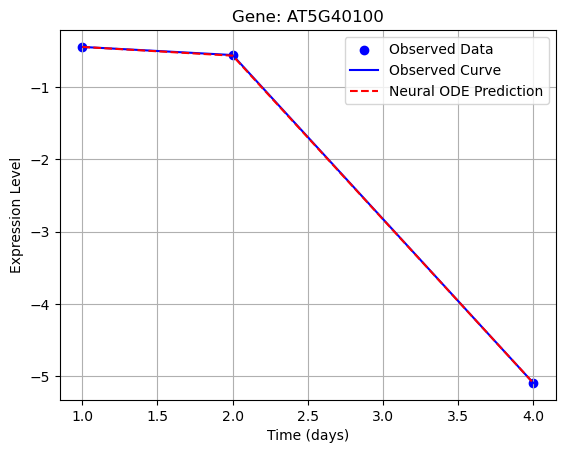

Learned ODE for Gene AT5G40100:
  dy/dt = 0.1877 + 0.6471 * y + 0.6471 * t
Formatted ODE Equation: dy/dt = 0.1877 + 0.6471 * y(t) * 0.6471 * t



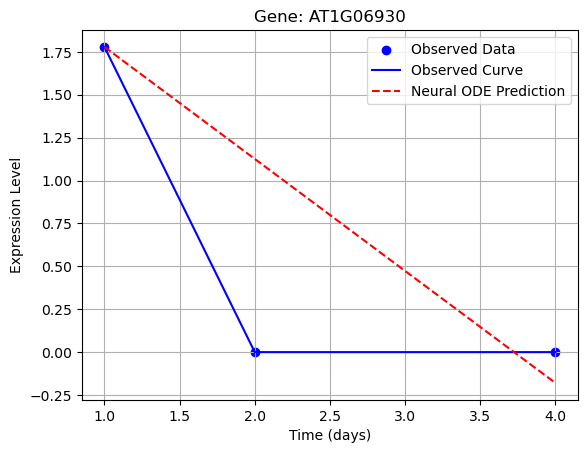

Learned ODE for Gene AT1G06930:
  dy/dt = -0.6526 + 0.0000 * y + -0.0000 * t
Formatted ODE Equation: dy/dt = -0.6526 + 0.0000 * y(t) * -0.0000 * t



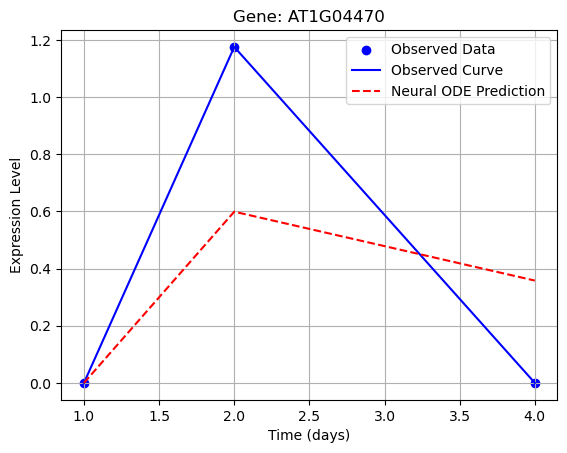

Learned ODE for Gene AT1G04470:
  dy/dt = 1.1645 + 0.9428 * y + -0.9427 * t
Formatted ODE Equation: dy/dt = 1.1645 + 0.9428 * y(t) * -0.9427 * t



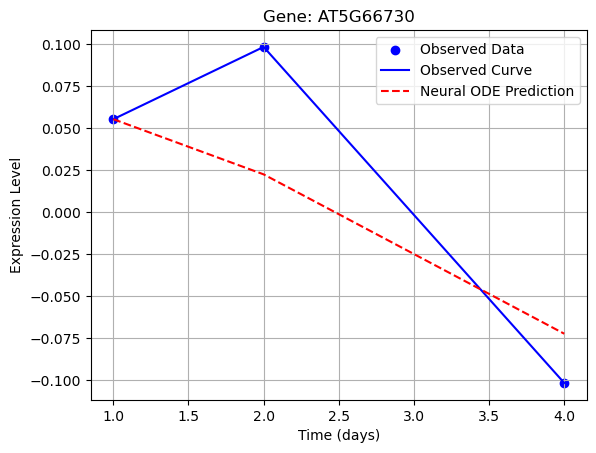

Learned ODE for Gene AT5G66730:
  dy/dt = -0.0392 + -0.3379 * y + -0.3379 * t
Formatted ODE Equation: dy/dt = -0.0392 + -0.3379 * y(t) * -0.3379 * t



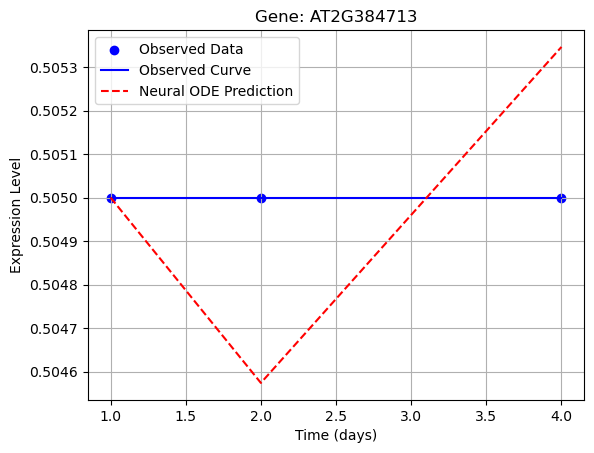

Learned ODE for Gene AT2G384713:
  dy/dt = -0.0012 + -0.0327 * y + -0.0327 * t
Formatted ODE Equation: dy/dt = -0.0012 + -0.0327 * y(t) * -0.0327 * t



In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

##############################################################################
# Data Setup (Row-wise: Each row is a gene; columns are Day1, Day2, Day4)
##############################################################################

# Example dataset (here using gene names and expression values)
# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
#     "Hpa-NO_1d": [-0.44796, 1.77836, 0.0, 0.05537],
#     "Hpa-NO_2d": [-0.56015, 0.0, 1.17515, 0.09843],
#     "Hpa-NO_4d": [-5.09196, 0.0, 0.0, -0.10176],
# }


data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G384713"],
    "Hpa-NO_1d":  [-0.44796,    1.77836,     0.0,         0.05537,    0.505000   ],
    "Hpa-NO_2d":  [-0.56015,    0.0,         1.17515,     0.09843,  0.505000   ],
    "Hpa-NO_4d":  [-5.09196,    0.0,         0.0,        -0.10176,  0.505000   ],
}


df = pd.DataFrame(data)
print("Original Data:")
print(df)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# Extract gene expression data (each row is one gene)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t
##############################################################################

class GeneParametricODE(nn.Module):
    def __init__(self):
        super(GeneParametricODE, self).__init__()
        # Learnable parameters: α, β, and γ
        self.alpha = nn.Parameter(torch.tensor(0.1))
        self.beta = nn.Parameter(torch.tensor(0.1))
        self.gamma = nn.Parameter(torch.tensor(0.1))
    
    def forward(self, t, y):
        # ODE: dy/dt = α + β * y(t) * γ * t
        return self.alpha + self.beta * y * self.gamma * t

# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

##############################################################################
# Inverse PINN Loss Function (Data Loss + Physics Loss)
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]
    
    for i in range(n_genes):
        # Observed expression for gene i (shape: (num_time_points,))
        y_observed = gene_data[i]
        # Use the first time point as the initial condition
        y0 = y_observed[0].unsqueeze(0)  # shape: (1,)
        
        # Solve the ODE for gene i over the time points
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)
        
        # Data loss: Mean squared error between predictions and observed values
        data_loss = torch.mean((preds - y_observed)**2)
        
        # Physics loss: Enforce that the derivative from autograd matches the ODE output
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]
        
        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)
        
        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)
        
        total_data_loss += data_loss
        total_physics_loss += physics_loss
    
    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 500

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
    total_loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")

##############################################################################
# Plotting Predictions and Printing Learned ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Gene']):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()
        
        # Plot observed data vs. Neural ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) * {gamma:.4f} * t\n")


# INVERSE PINN

    # ODE: dy/dt = a * y + b
    ode_residual = y_t - (model.a * y_pred + model.b)

Training PINN for Gene 1...
y_data:  tensor([[-0.4480],
        [-0.5602],
        [-5.0920]])
Gene 1, Epoch 0, Loss: 9.42779541015625
Gene 1, Epoch 100, Loss: 0.019354529678821564
Gene 1, Epoch 200, Loss: 0.0061852168291807175
Gene 1, Epoch 300, Loss: 0.0020354005973786116
Gene 1, Epoch 400, Loss: 0.00040905451169237494
Gene 1, Epoch 500, Loss: 4.0587798139313236e-05
Gene 1, Epoch 600, Loss: 0.003929966129362583
Gene 1, Epoch 700, Loss: 3.418134326693689e-07
Gene 1, Epoch 800, Loss: 2.517695829595823e-09
Gene 1, Epoch 900, Loss: 1.5143317155796865e-11
Training PINN for Gene 2...
y_data:  tensor([[1.7784],
        [0.0000],
        [0.0000]])
Gene 2, Epoch 0, Loss: 1.9772975444793701
Gene 2, Epoch 100, Loss: 0.03260741010308266
Gene 2, Epoch 200, Loss: 0.007249491289258003
Gene 2, Epoch 300, Loss: 0.0012796488590538502
Gene 2, Epoch 400, Loss: 0.00012183609214844182
Gene 2, Epoch 500, Loss: 8.82479980646167e-06
Gene 2, Epoch 600, Loss: 4.192376081846305e-07
Gene 2, Epoch 700, Loss: 1.2

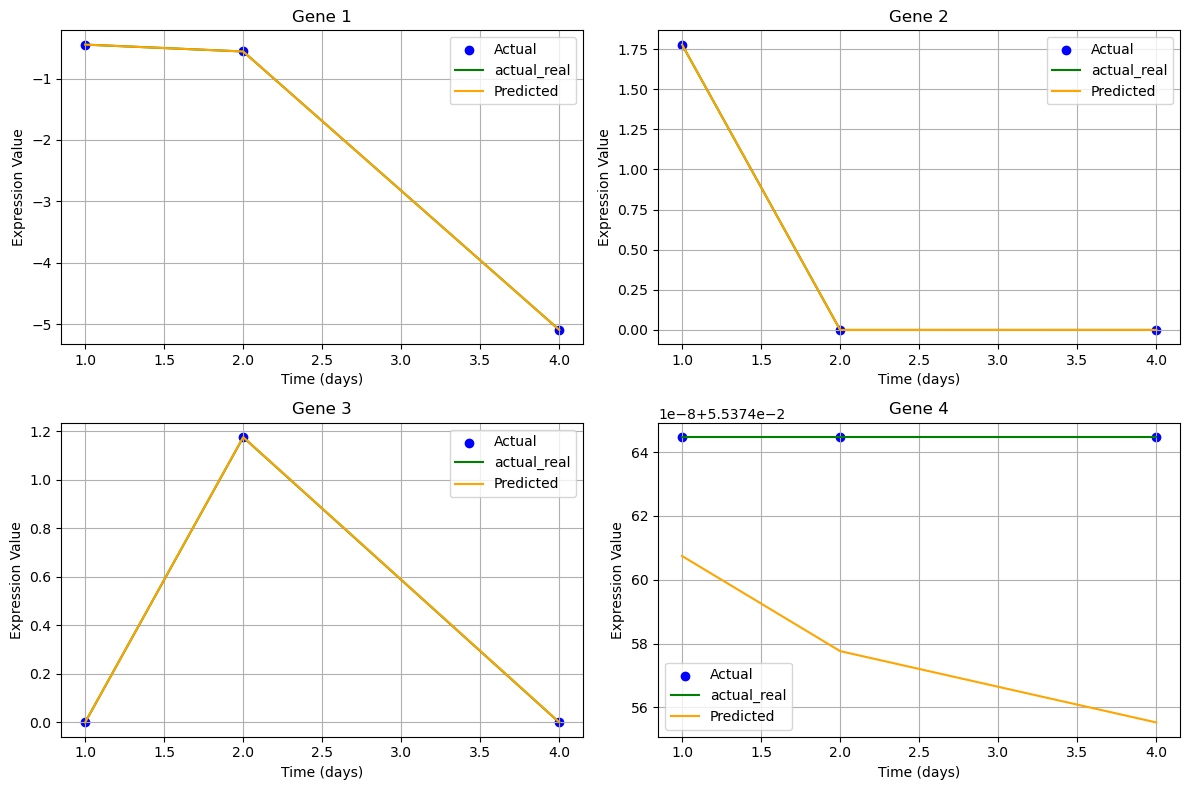

model:  PINN(
  (hidden): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
a Parameter containing:
tensor(0.8123, requires_grad=True)
b Parameter containing:
tensor(0.4041, requires_grad=True)
model:  PINN(
  (hidden): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
a Parameter containing:
tensor(1.2331, requires_grad=True)
b Parameter containing:
tensor(0.0092, requires_grad=True)
model:  PINN(
  (hidden): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
a 

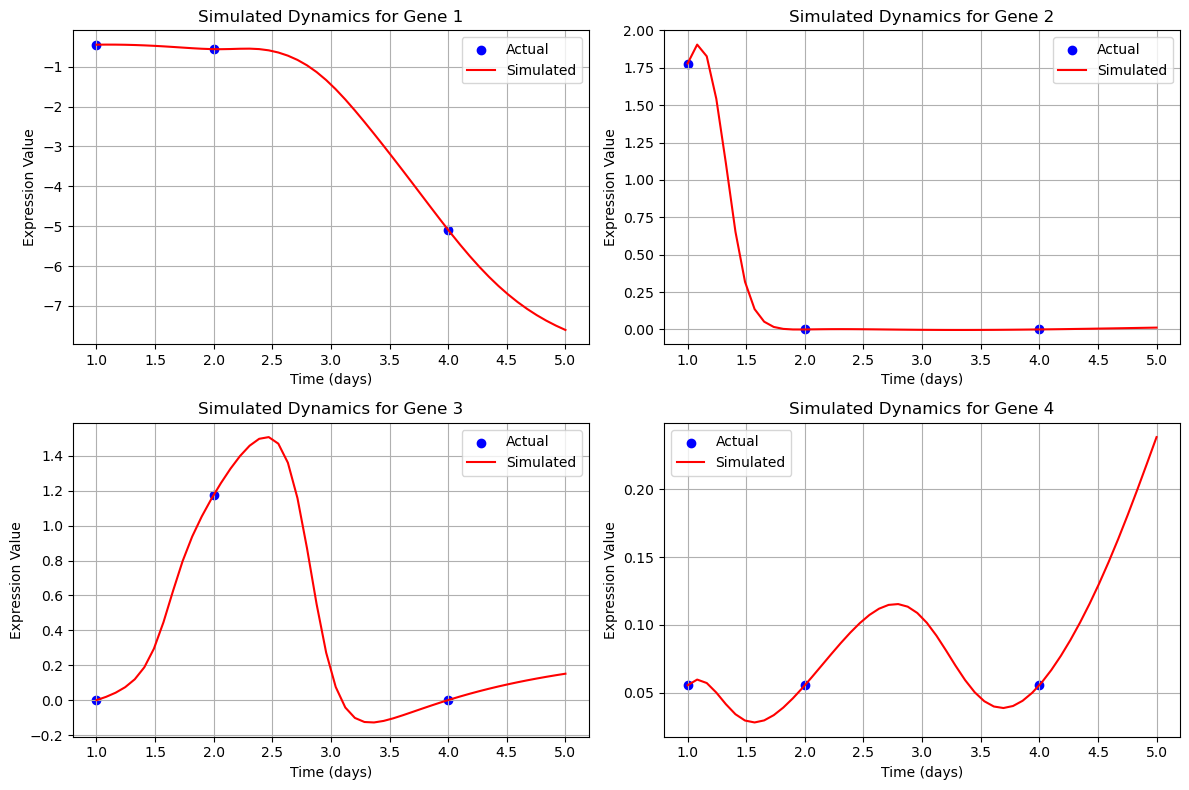

In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Dataset (time points and gene expression values)
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).view(-1, 1)  # Time: t = 1, 2, 4
expression_values = torch.tensor(
    [
        [-0.44796003, -0.560154646, -5.091964284],  # AT5G40100
        [1.778358524, 0.0, 0.0],                   # AT1G06930
        [0.0, 1.175149691, 0.0],                   # AT1G04470
        [0.055374646, 0.055374646, 0.055374646],  # AT5G66730
    ],
    dtype=torch.float32,
)

# PINN Model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        # Parameters for the ODE
        self.a = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Parameter a
        self.b = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Parameter b

    def forward(self, t):
        return self.hidden(t)

# Loss function for inverse PINN
def loss_fn(model, t, y_data):
    y_pred = model(t)
    y_t = torch.autograd.grad(
        y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True
    )[0]
    # ODE: dy/dt = a * y + b
    ode_residual = y_t - (model.a * y_pred + model.b)
    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)
    return data_loss + physics_loss

# Training PINN for each gene
def train_pinn_for_gene(time_points, expression_values, gene_index, epochs=1000, lr=0.01):
    y_data = expression_values[gene_index].view(-1, 1)
    print("y_data: ", y_data)
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        # Time points
        time_points = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)  # This line is already correct
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Gene {gene_index + 1}, Epoch {epoch}, Loss: {loss.item()}")
    return model

# Train PINN for all genes
models = []
for i in range(expression_values.shape[0]):
    print(f"Training PINN for Gene {i + 1}...")
    model = train_pinn_for_gene(time_points, expression_values, i)
    models.append(model)

# Output estimated parameters
for i, model in enumerate(models):
    print(f"Gene {i + 1}: a = {model.a.item():.4f}, b = {model.b.item():.4f}")

# Plot predictions vs. actual data for each gene
plt.figure(figsize=(12, 8))
for i, model in enumerate(models):
    y_pred = model(time_points).detach().numpy()
    plt.subplot(2, 2, i + 1)
    plt.scatter(time_points.numpy(), expression_values[i].numpy(), color="blue", label="Actual")
    plt.plot(time_points.numpy(), expression_values[i].numpy(), color="green", label="actual_real")
    plt.plot(time_points.numpy(), y_pred, color="orange", label="Predicted")
    plt.title(f"Gene {i + 1}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Generate new data using the trained ODEs
new_time_points = torch.linspace(1, 5, 50).view(-1, 1)  # New time points for simulation
plt.figure(figsize=(12, 8))
for i, model in enumerate(models):
    print("model: ", model)
    print("a", model.a)
    print("b", model.b)
    y_new = model(new_time_points).detach().numpy()
    plt.subplot(2, 2, i + 1)
    plt.scatter(time_points.numpy(), expression_values[i].numpy(), color="blue", label="Actual")

    plt.plot(new_time_points.numpy(), y_new, color="red", label="Simulated")
    plt.title(f"Simulated Dynamics for Gene {i + 1}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# INVERSE PINN

##      ODE: dy/dt = a * y + b
    ode_residual = y_t - (model.a * y_pred + model.b)

Training PINN for Gene 1...
Gene 1, Epoch 0, Loss: 7.417261600494385
Gene 1, Epoch 100, Loss: 0.5912607908248901
Gene 1, Epoch 200, Loss: 0.07523936033248901
Training PINN for Gene 2...
Gene 2, Epoch 0, Loss: 2.86942982673645
Gene 2, Epoch 100, Loss: 0.11244143545627594
Gene 2, Epoch 200, Loss: 0.02865852788090706
Training PINN for Gene 3...
Gene 3, Epoch 0, Loss: 1.8155710697174072
Gene 3, Epoch 100, Loss: 0.30732107162475586
Gene 3, Epoch 200, Loss: 0.03820059821009636
Training PINN for Gene 4...
Gene 4, Epoch 0, Loss: 2.190298318862915
Gene 4, Epoch 100, Loss: 0.09075851738452911
Gene 4, Epoch 200, Loss: 0.01199246384203434
Gene 1: a = 0.0037, b = 0.0132
Gene 2: a = -0.0009, b = 0.0013
Gene 3: a = 0.1219, b = -0.0708
Gene 4: a = 1.0756, b = -0.0041


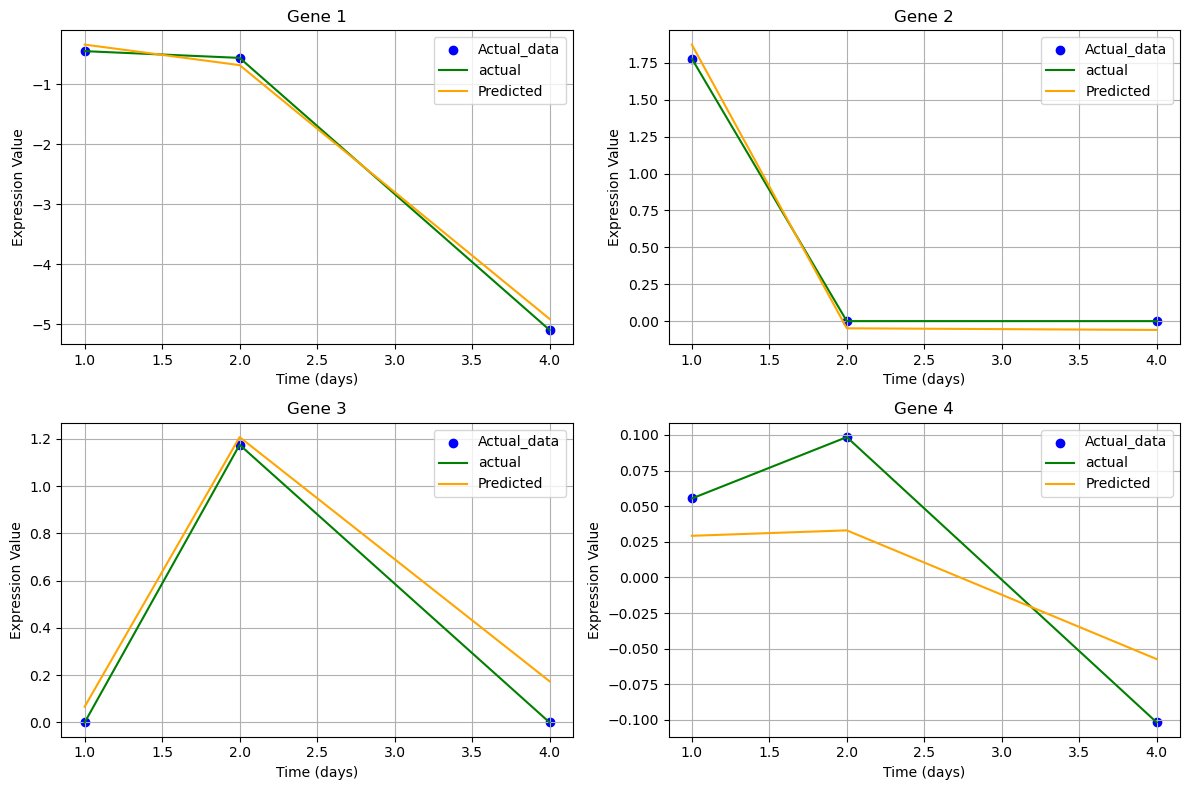

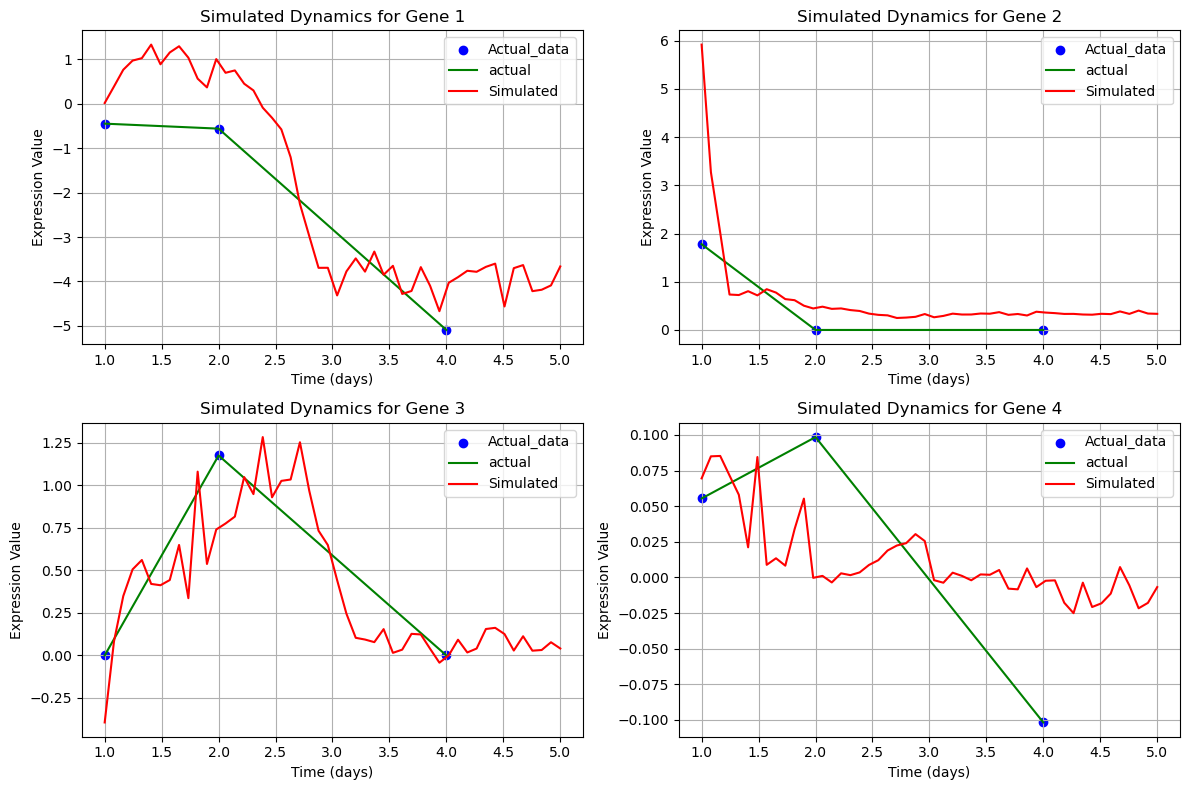

In [23]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Dataset (time points and gene expression values)
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).view(-1, 1)  # Time: t = 1, 2, 4
expression_values = torch.tensor(
    [
        [-0.44796003, -0.560154646, -5.091964284],  # AT5G40100
        [1.778358524, 0.0, 0.0],                   # AT1G06930
        [0.0, 1.175149691, 0.0],                   # AT1G04470
        [0.055374646, 0.098434984, -0.101756864],  # AT5G66730
    ],
    dtype=torch.float32,
)

# PINN Model with LSTM, Dropout, and Normalization
class AdvancedPINN(nn.Module):
    def __init__(self):
        super(AdvancedPINN, self).__init__()
        self.pre_lstm = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.BatchNorm1d(50),
            nn.Dropout(0.2),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.BatchNorm1d(100),
            nn.Dropout(0.2)
        )
        self.lstm = nn.LSTM(input_size=100, hidden_size=100, num_layers=2, batch_first=True, dropout=0.2)
        self.post_lstm = nn.Sequential(
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.BatchNorm1d(50),
            nn.Dropout(0.2),
            nn.Linear(50, 1)
        )
        # Parameters for the ODE
        self.a = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Parameter a
        self.b = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Parameter b

    def forward(self, t):
        t_preprocessed = self.pre_lstm(t)
        t_preprocessed = t_preprocessed.unsqueeze(0)  # Add batch dimension for LSTM
        lstm_out, _ = self.lstm(t_preprocessed)
        lstm_out = lstm_out.squeeze(0)  # Remove batch dimension
        return self.post_lstm(lstm_out)

# Loss function for inverse PINN
def loss_fn(model, t, y_data):
    y_pred = model(t)
    y_t = torch.autograd.grad(
        y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True
    )[0]
    # ODE: dy/dt = a * y + b
    ode_residual = y_t - (model.a * y_pred + model.b)
    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)
    return data_loss + physics_loss

# Training PINN for each gene
def train_pinn_for_gene(time_points, expression_values, gene_index, epochs=300, lr=0.01):
    y_data = expression_values[gene_index].view(-1, 1)
    model = AdvancedPINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        time_points = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Gene {gene_index + 1}, Epoch {epoch}, Loss: {loss.item()}")
    return model

# Train PINN for all genes
models = []
for i in range(expression_values.shape[0]):
    print(f"Training PINN for Gene {i + 1}...")
    model = train_pinn_for_gene(time_points, expression_values, i)
    models.append(model)

# Output estimated parameters
for i, model in enumerate(models):
    print(f"Gene {i + 1}: a = {model.a.item():.4f}, b = {model.b.item():.4f}")

# Plot predictions vs. actual data for each gene
plt.figure(figsize=(12, 8))
for i, model in enumerate(models):
    y_pred = model(time_points).detach().numpy()
    plt.subplot(2, 2, i + 1)
    plt.scatter(time_points.numpy(), expression_values[i].numpy(), color="blue", label="Actual_data")
    plt.plot(time_points.numpy(), expression_values[i].numpy(), color="green", label="actual")
    plt.plot(time_points.numpy(), y_pred, color="orange", label="Predicted")
    plt.title(f"Gene {i + 1}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Generate new data using the trained ODEs
new_time_points = torch.linspace(1, 5, 50).view(-1, 1)  # New time points for simulation
plt.figure(figsize=(12, 8))
for i, model in enumerate(models):
    y_new = model(new_time_points).detach().numpy()
    plt.subplot(2, 2, i + 1)
    plt.scatter(time_points.numpy(), expression_values[i].numpy(), color="blue", label="Actual_data")
    plt.plot(time_points.numpy(), expression_values[i].numpy(), color="green", label="actual")

    plt.plot(new_time_points.numpy(), y_new, color="red", label="Simulated")
    plt.title(f"Simulated Dynamics for Gene {i + 1}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# Inverse PINN

##  ODE parameters for: dy/dt = α + β * y(t) + γ * t
    
    
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * t.squeeze())


AT5G40100 - Epoch 0, Loss: 21.9041
AT5G40100 - Epoch 100, Loss: 0.2047
AT5G40100 - Epoch 200, Loss: 0.0238
AT5G40100 - Epoch 300, Loss: 0.0125
AT5G40100 - Epoch 400, Loss: 0.0038
AT5G40100 - Epoch 500, Loss: 0.0016
AT5G40100 - Epoch 600, Loss: 0.0009
AT5G40100 - Epoch 700, Loss: 0.0002
AT5G40100 - Epoch 800, Loss: 0.0000
AT5G40100 - Epoch 900, Loss: 0.0013


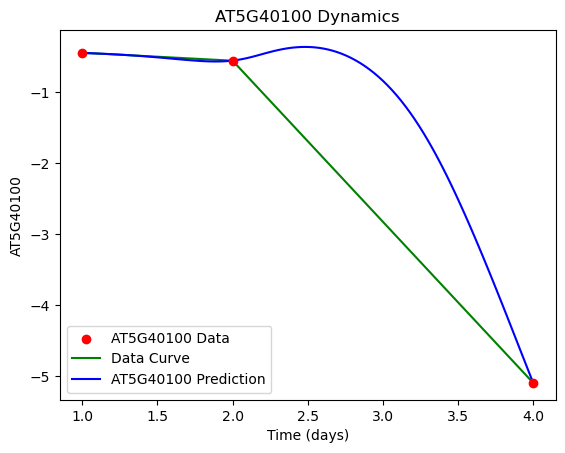

AT1G06930 - Epoch 0, Loss: 13.4307
AT1G06930 - Epoch 100, Loss: 0.3763
AT1G06930 - Epoch 200, Loss: 0.0001
AT1G06930 - Epoch 300, Loss: 0.0000
AT1G06930 - Epoch 400, Loss: 0.0000
AT1G06930 - Epoch 500, Loss: 0.0000
AT1G06930 - Epoch 600, Loss: 0.0000
AT1G06930 - Epoch 700, Loss: 0.0000
AT1G06930 - Epoch 800, Loss: 0.0039
AT1G06930 - Epoch 900, Loss: 0.0000


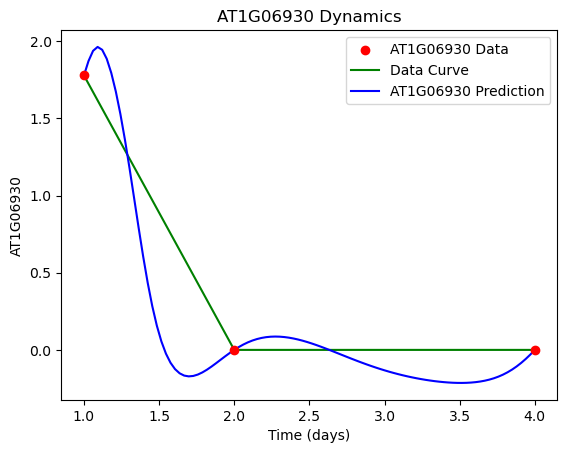

AT1G04470 - Epoch 0, Loss: 14.2844
AT1G04470 - Epoch 100, Loss: 0.6269
AT1G04470 - Epoch 200, Loss: 0.0000
AT1G04470 - Epoch 300, Loss: 0.0000
AT1G04470 - Epoch 400, Loss: 0.0000
AT1G04470 - Epoch 500, Loss: 0.0000
AT1G04470 - Epoch 600, Loss: 0.0000
AT1G04470 - Epoch 700, Loss: 0.0000
AT1G04470 - Epoch 800, Loss: 0.0000
AT1G04470 - Epoch 900, Loss: 0.0000


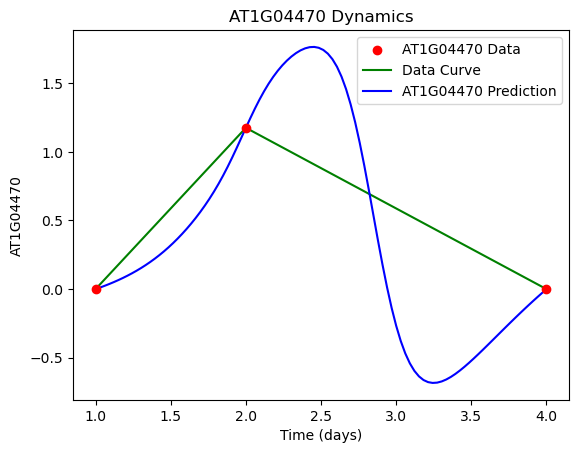

AT5G66730 - Epoch 0, Loss: 15.2327
AT5G66730 - Epoch 100, Loss: 0.2147
AT5G66730 - Epoch 200, Loss: 0.0280
AT5G66730 - Epoch 300, Loss: 0.0088
AT5G66730 - Epoch 400, Loss: 0.0006
AT5G66730 - Epoch 500, Loss: 0.0000
AT5G66730 - Epoch 600, Loss: 0.0000
AT5G66730 - Epoch 700, Loss: 0.0000
AT5G66730 - Epoch 800, Loss: 0.0000
AT5G66730 - Epoch 900, Loss: 0.0000


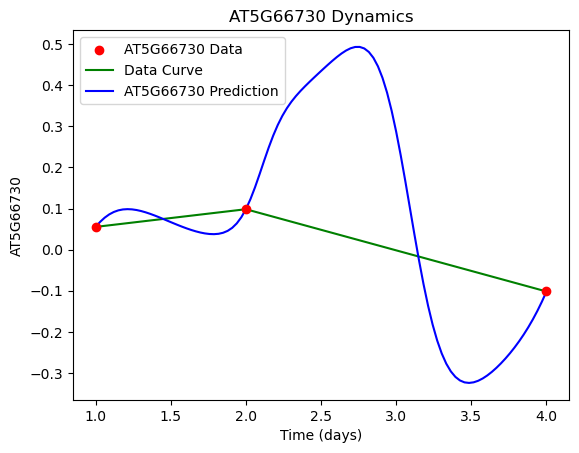

AT2G38471 - Epoch 0, Loss: 12.4578
AT2G38471 - Epoch 100, Loss: 0.2255
AT2G38471 - Epoch 200, Loss: 0.0001
AT2G38471 - Epoch 300, Loss: 0.0000
AT2G38471 - Epoch 400, Loss: 0.0000
AT2G38471 - Epoch 500, Loss: 0.0000
AT2G38471 - Epoch 600, Loss: 0.0005
AT2G38471 - Epoch 700, Loss: 0.0000
AT2G38471 - Epoch 800, Loss: 0.0000
AT2G38471 - Epoch 900, Loss: 0.0000


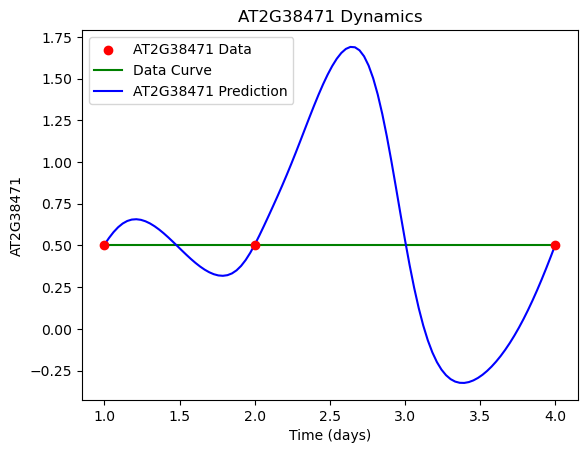

AT2G38472 - Epoch 0, Loss: 13.6366
AT2G38472 - Epoch 100, Loss: 0.5937
AT2G38472 - Epoch 200, Loss: 0.1038
AT2G38472 - Epoch 300, Loss: 0.0231
AT2G38472 - Epoch 400, Loss: 0.0000
AT2G38472 - Epoch 500, Loss: 0.0000
AT2G38472 - Epoch 600, Loss: 0.0000
AT2G38472 - Epoch 700, Loss: 0.0000
AT2G38472 - Epoch 800, Loss: 0.0000
AT2G38472 - Epoch 900, Loss: 0.0000


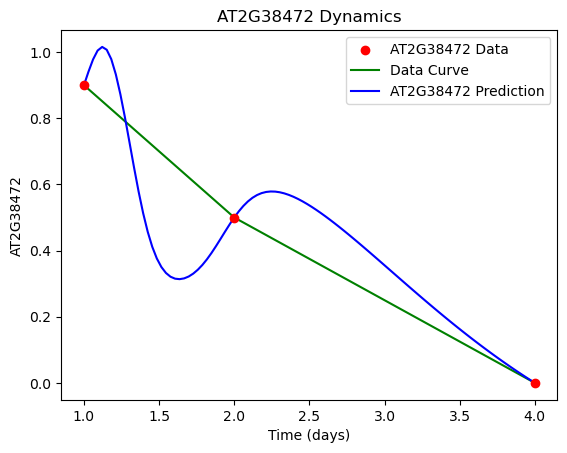

AT2G38473 - Epoch 0, Loss: 15.1844
AT2G38473 - Epoch 100, Loss: 0.4602
AT2G38473 - Epoch 200, Loss: 0.0000
AT2G38473 - Epoch 300, Loss: 0.0000
AT2G38473 - Epoch 400, Loss: 0.0000
AT2G38473 - Epoch 500, Loss: 0.0000
AT2G38473 - Epoch 600, Loss: 0.0000
AT2G38473 - Epoch 700, Loss: 0.0000
AT2G38473 - Epoch 800, Loss: 0.0001
AT2G38473 - Epoch 900, Loss: 0.0000


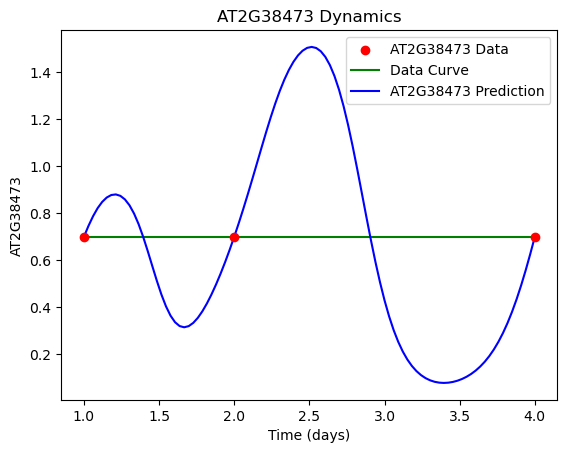

AT2G38474 - Epoch 0, Loss: 10.9374
AT2G38474 - Epoch 100, Loss: 0.3606
AT2G38474 - Epoch 200, Loss: 0.0057
AT2G38474 - Epoch 300, Loss: 0.0014
AT2G38474 - Epoch 400, Loss: 0.0004
AT2G38474 - Epoch 500, Loss: 0.0001
AT2G38474 - Epoch 600, Loss: 0.0000
AT2G38474 - Epoch 700, Loss: 0.0001
AT2G38474 - Epoch 800, Loss: 0.0000
AT2G38474 - Epoch 900, Loss: 0.0000


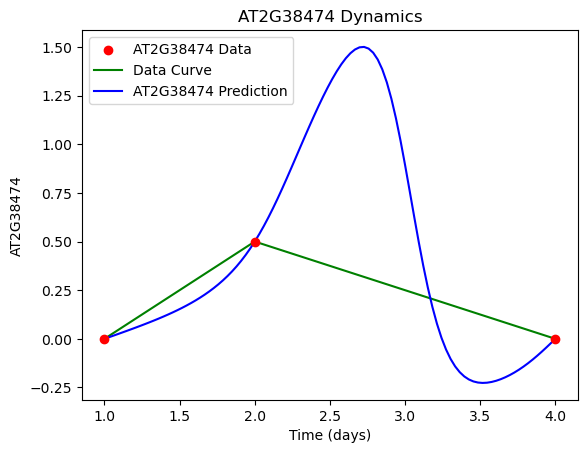

AT2G38470 - Epoch 0, Loss: 13.9535
AT2G38470 - Epoch 100, Loss: 0.5012
AT2G38470 - Epoch 200, Loss: 0.0000
AT2G38470 - Epoch 300, Loss: 0.0011
AT2G38470 - Epoch 400, Loss: 0.0000
AT2G38470 - Epoch 500, Loss: 0.0000
AT2G38470 - Epoch 600, Loss: 0.0000
AT2G38470 - Epoch 700, Loss: 0.0036
AT2G38470 - Epoch 800, Loss: 0.0000
AT2G38470 - Epoch 900, Loss: 0.0000


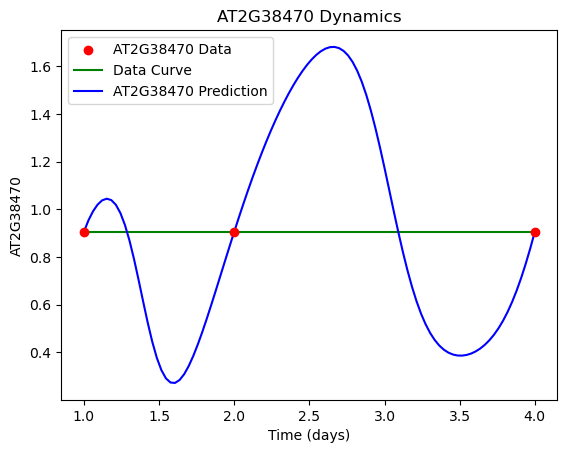

AT5G40100: alpha = 0.126422, beta = 1.427553, gamma = 0.458940
AT1G06930: alpha = 0.240050, beta = 1.620954, gamma = 0.199782
AT1G04470: alpha = 0.190649, beta = 1.558723, gamma = 0.188177
AT5G66730: alpha = 0.133287, beta = 1.580832, gamma = 0.218977
AT2G38471: alpha = 0.289210, beta = 1.505064, gamma = 0.336179
AT2G38472: alpha = -0.053002, beta = 1.636983, gamma = -0.058540
AT2G38473: alpha = 0.258616, beta = 1.473150, gamma = 0.293455
AT2G38474: alpha = 0.113050, beta = 1.596751, gamma = 0.159238
AT2G38470: alpha = 0.191304, beta = 1.516938, gamma = 0.199957


In [24]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network that approximates y(t)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Single output: y(t)
        )
        # Learnable ODE parameters for: dy/dt = α + β * y(t) + γ * t
        self.alpha = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.beta  = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Define the loss function with data and physics (ODE) components
def loss_fn(model, t, y_data):
    # Get the predicted y(t)
    y_pred = model(t).squeeze()  # Shape: (num_time_points,)
    
    # Compute dy/dt via autograd
    y_t = torch.autograd.grad(
        y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True
    )[0].squeeze()  # Shape: (num_time_points,)
    
    # Compute the ODE residual: dy/dt should equal α + β*y(t) + γ*t
    # We squeeze t to have the same shape as y_pred
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * t.squeeze())
    
    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)
    
    return data_loss + physics_loss

# Data: Each gene has expression values at Day1, Day2, Day4
data = {
    "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    "AT1G06930": [1.778358524, 0, 0],
    "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

# Time points as a tensor: shape (3, 1)
time_points = torch.tensor([[1.0], [2.0], [4.0]], dtype=torch.float32, requires_grad=True)

results = {}

# Loop over each gene
for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)
    
    # Initialize the neural network model for this gene
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop
    epochs = 1000
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item():.4f}")
    
    # Save the learned parameters
    results[gene] = {
        "alpha": model.alpha.item(),
        "beta": model.beta.item(),
        "gamma": model.gamma.item()
    }
    
    # Generate predictions for plotting over a smooth time grid
    t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1)
    y_pred = model(t_test).detach().numpy()
    
    # Plot observed data vs. Neural ODE predictions
    plt.figure()
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)
    plt.plot(time_points.detach().numpy(), y_data.numpy(), color='green', label='Data Curve', zorder=3)
    plt.plot(t_test.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)
    plt.title(f'{gene} Dynamics')
    plt.xlabel('Time (days)')
    plt.ylabel(gene)
    plt.legend()
    plt.show()

# Print the learned parameters for each gene
for gene, params in results.items():
    print(f"{gene}: alpha = {params['alpha']:.6f}, beta = {params['beta']:.6f}, gamma = {params['gamma']:.6f}")


# neural ODE + Inverse PINN
    def forward(self, t, y):
        # dy/dt = α + β*y + γ*t
        return self.alpha + self.beta * y + self.gamma * t

Epoch    0 | Loss: 0.9861 | Data: 0.9776 | Physics: 0.0856
Epoch  300 | Loss: 0.0987 | Data: 0.0524 | Physics: 0.4627
Epoch  600 | Loss: 0.0700 | Data: 0.0342 | Physics: 0.3581
Epoch  900 | Loss: 0.0685 | Data: 0.0328 | Physics: 0.3567


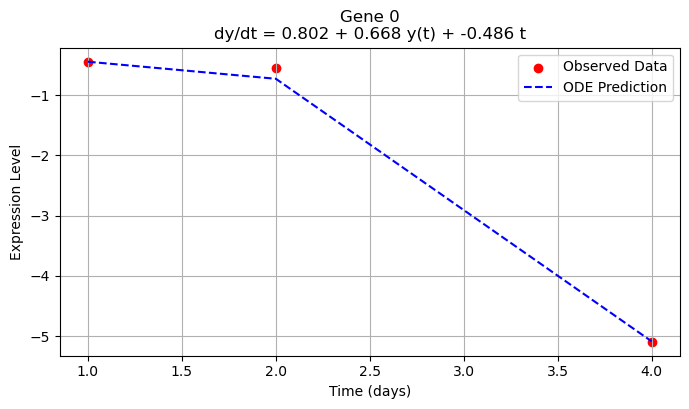

Gene 0:
  α = 0.802, β = 0.668, γ = -0.486



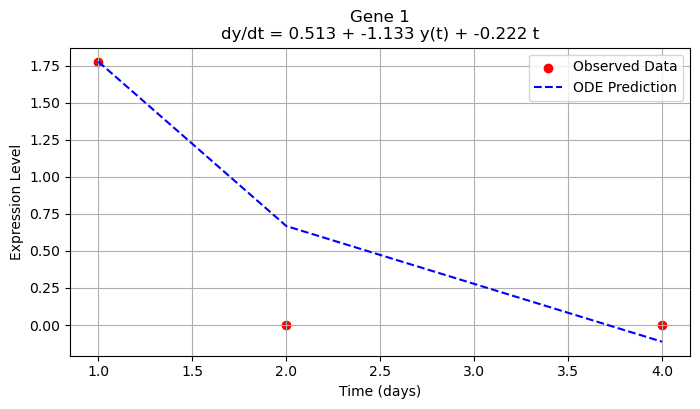

Gene 1:
  α = 0.513, β = -1.133, γ = -0.222



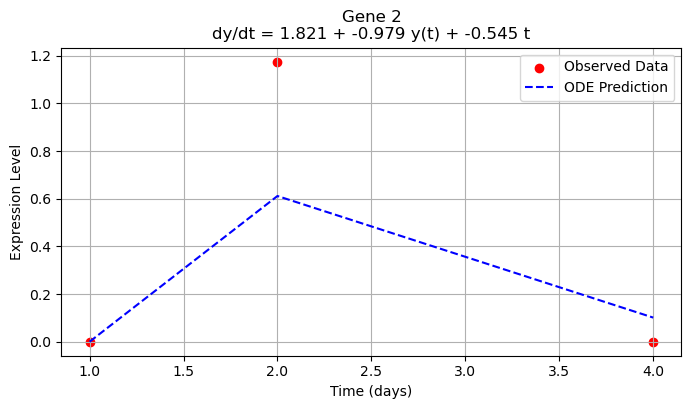

Gene 2:
  α = 1.821, β = -0.979, γ = -0.545



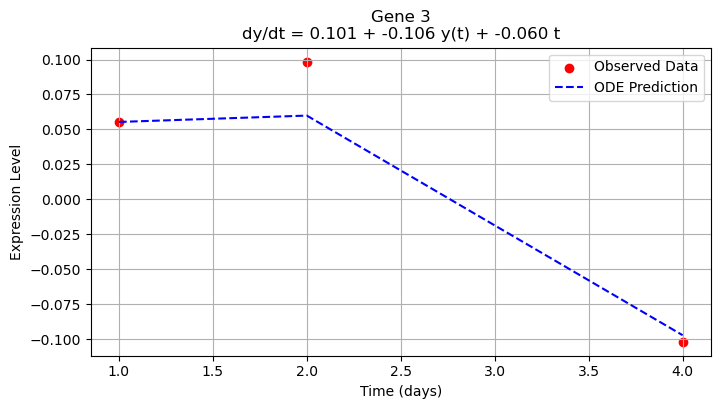

Gene 3:
  α = 0.101, β = -0.106, γ = -0.060



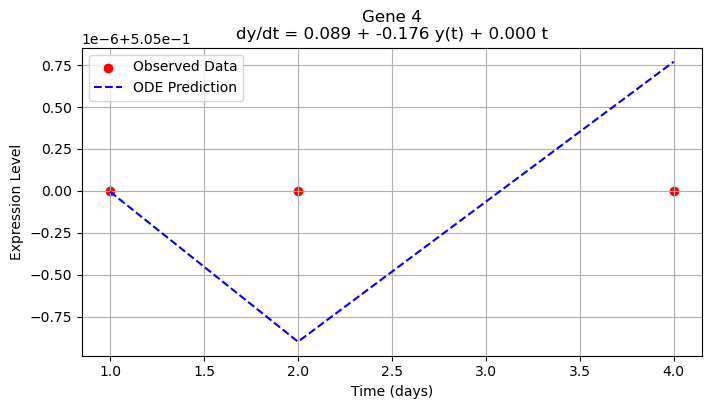

Gene 4:
  α = 0.089, β = -0.176, γ = 0.000



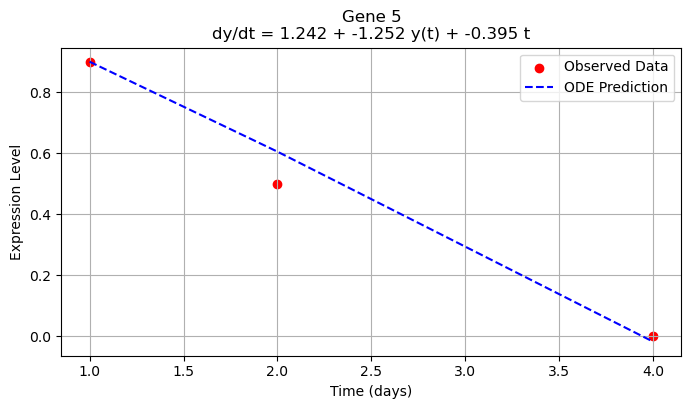

Gene 5:
  α = 1.242, β = -1.252, γ = -0.395



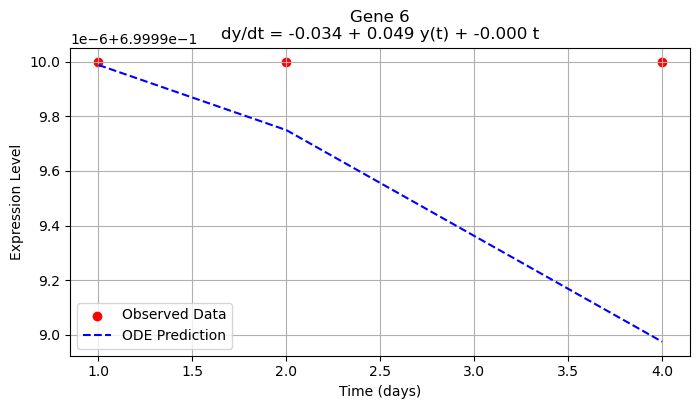

Gene 6:
  α = -0.034, β = 0.049, γ = -0.000



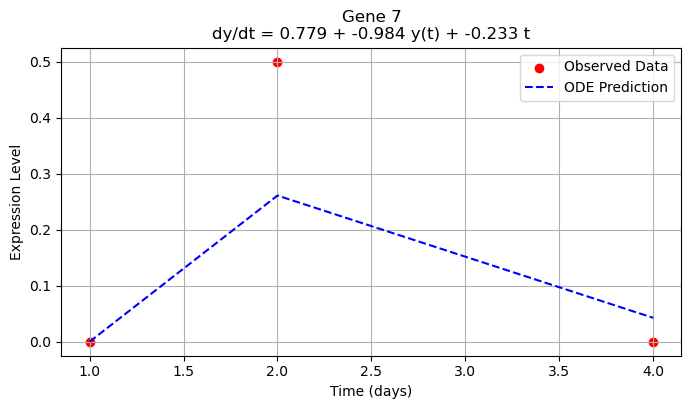

Gene 7:
  α = 0.779, β = -0.984, γ = -0.233



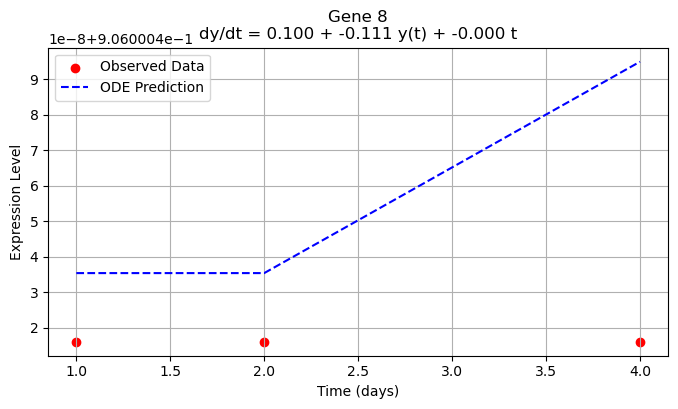

Gene 8:
  α = 0.100, β = -0.111, γ = -0.000



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Load dataset (genes as rows, time points as columns)
df = df
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Days 1, 2, 4
# gene_data = df.values.astype(np.float32)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values


# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Neural ODE Model (Parametric ODE with Learnable Parameters)
##############################################################################

class GeneODE(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize parameters (α, β, γ)
        self.alpha = nn.Parameter(torch.randn(1) * 0.1)
        self.beta = nn.Parameter(torch.randn(1) * 0.1)
        self.gamma = nn.Parameter(torch.randn(1) * 0.1)

    def forward(self, t, y):
        # dy/dt = α + β*y + γ*t
        return self.alpha + self.beta * y + self.gamma * t

# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneODE() for _ in range(num_genes)])

##############################################################################
# Inverse PINN Loss Function
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    
    for i in range(len(ode_models)):
        y_observed = gene_data[i]
        y0 = y_observed[0].unsqueeze(0)
        
        # Solve ODE for current gene
        preds = odeint(ode_models[i], y0, time_points).squeeze()
        
        # Data loss (MSE between predictions and data)
        data_loss = torch.mean((preds - y_observed)**2)
        
        # Physics loss (ensure predictions satisfy ODE structure)
        # Compute dy/dt from predictions
        dy_dt_pred = torch.autograd.grad(
            preds, time_points, grad_outputs=torch.ones_like(preds),
            create_graph=True, retain_graph=True
        )[0]
        
        # Compute dy/dt from the ODE model
        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)
        
        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)
        
        total_data_loss += data_loss
        total_physics_loss += physics_loss
    
    avg_data_loss = total_data_loss / len(ode_models)
    avg_physics_loss = total_physics_loss / len(ode_models)
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 1000

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(
        ode_models, time_points_tensor, gene_data_tensor
    )
    total_loss.backward()
    optimizer.step()
    
    if epoch % 300 == 0:
        print(f"Epoch {epoch:4d} | Loss: {total_loss.item():.4f} | Data: {data_loss.item():.4f} | Physics: {physics_loss.item():.4f}")

##############################################################################
# Results: Learned ODEs and Plots
##############################################################################

for i, gene_id in enumerate(df.index):
    # Extract learned parameters
    α = ode_models[i].alpha.item()
    β = ode_models[i].beta.item()
    γ = ode_models[i].gamma.item()
    
    # Define the ODE as a string
    ode_equation = f"dy/dt = {α:.3f} + {β:.3f} y(t) + {γ:.3f} t"
    
    # Solve the ODE for plotting
    y0 = gene_data_tensor[i, 0].unsqueeze(0)
    preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().detach().numpy()
    
    # Plot observed vs. predicted
    plt.figure(figsize=(8, 4))
    plt.scatter(time_points, gene_data[i], c='r', label='Observed Data')
    plt.plot(time_points, gene_data[i],  label='real Data')

    plt.plot(time_points, preds, 'b--', label='ODE Prediction')
    plt.title(f"Gene {gene_id}\n{ode_equation}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print parameters
    print(f"Gene {gene_id}:")
    print(f"  α = {α:.3f}, β = {β:.3f}, γ = {γ:.3f}\n")

# Inverse PINN

## ODE residual: dy/dt + k(t)*y(t) - c(t) = 0
    ode_residual = dy_dt + k * y_pred - c

Step 1: Define the Neural Networks for Time-Dependent Parameters


In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define neural networks for k(t) and c(t)
class TimeDependentParams(nn.Module):
    def __init__(self):
        super(TimeDependentParams, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),  # Input: time `t`
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2)   # Output: k(t) and c(t)
        )

    def forward(self, t):
        params = self.net(t)
        k = params[:, 0]
        c = params[:, 1]
        return k, c

# Main neural network for y(t)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        self.param_net = TimeDependentParams()  # Time-dependent k(t) and c(t)

    def forward(self, t):
        y_pred = self.hidden(t).squeeze()
        k, c = self.param_net(t)
        return y_pred, k, c

Step 2: Define the Physics-Informed Loss Function


In [ ]:
def loss_fn(model, t, y_data):
    y_pred, k, c = model(t)

    # Compute derivative dy/dt
    dy_dt = torch.autograd.grad(
        y_pred, t, 
        grad_outputs=torch.ones_like(y_pred), 
        create_graph=True
    )[0]

    # ODE residual: dy/dt + k(t)*y(t) - c(t) = 0
    ode_residual = dy_dt + k * y_pred - c

    # Loss terms
    data_loss = torch.mean((y_pred - y_data)**2)
    physics_loss = torch.mean(ode_residual**2)

    return data_loss + 1.0 * physics_loss

Step 3: Training Loop (Per Gene)


AT5G40100 - Epoch 0, Loss: 8.97464370727539
AT5G40100 - Epoch 100, Loss: 0.014693988487124443
AT5G40100 - Epoch 200, Loss: 5.363090735954756e-07


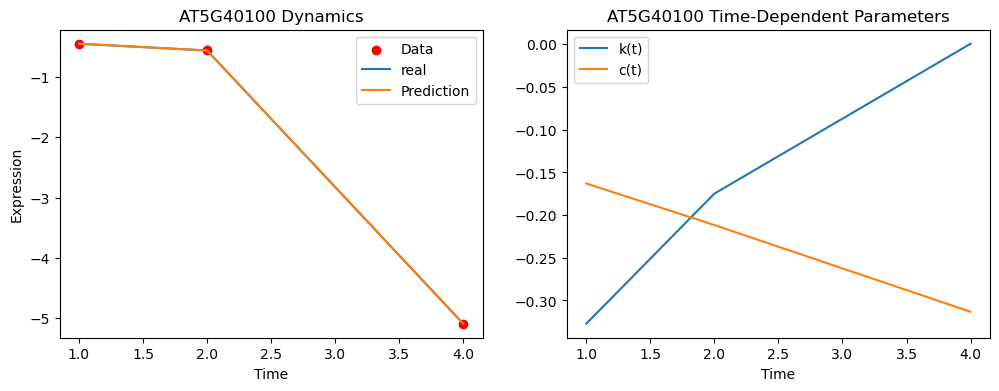

AT1G06930 - Epoch 0, Loss: 2.0471246242523193
AT1G06930 - Epoch 100, Loss: 0.0020125433802604675
AT1G06930 - Epoch 200, Loss: 2.1162598784485454e-08


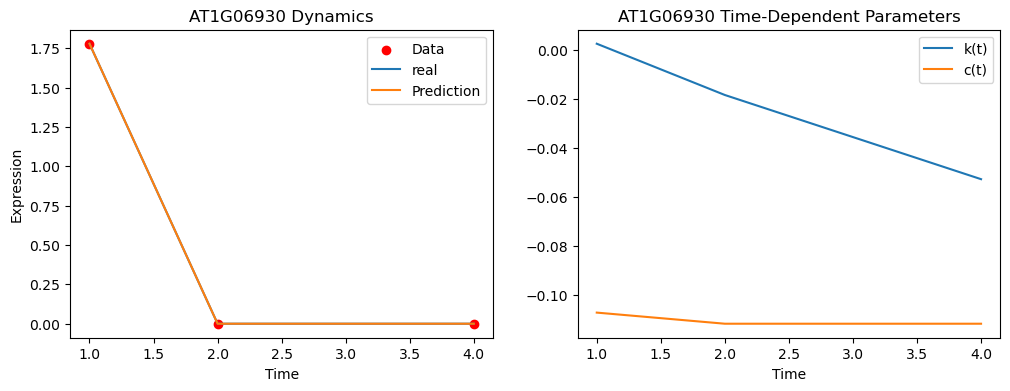

AT1G04470 - Epoch 0, Loss: 0.4168996512889862
AT1G04470 - Epoch 100, Loss: 0.25817498564720154
AT1G04470 - Epoch 200, Loss: 3.389906487427652e-05


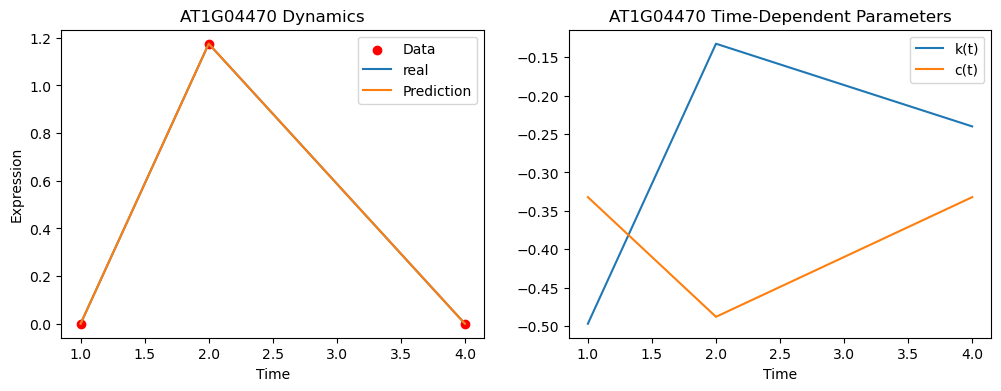

AT5G66730 - Epoch 0, Loss: 0.09744091331958771
AT5G66730 - Epoch 100, Loss: 0.0029084791895002127
AT5G66730 - Epoch 200, Loss: 0.0016383817419409752


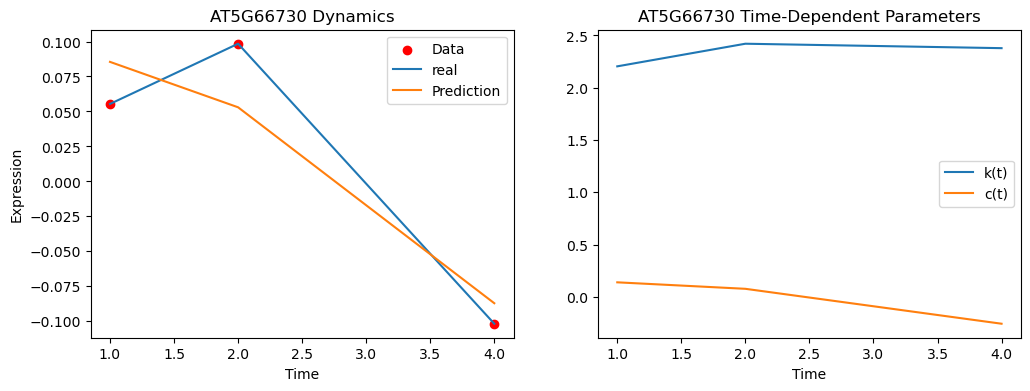

AT2G38471 - Epoch 0, Loss: 0.23198357224464417
AT2G38471 - Epoch 100, Loss: 8.934063771448564e-06
AT2G38471 - Epoch 200, Loss: 2.2134568098408636e-06


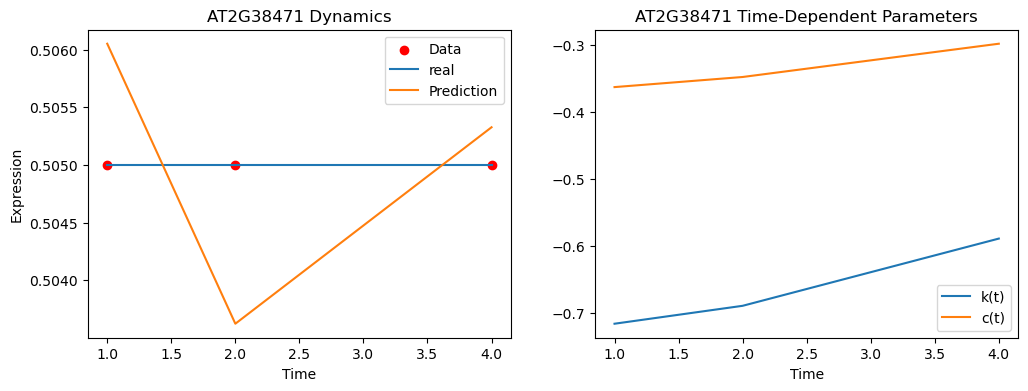

AT2G38472 - Epoch 0, Loss: 0.5989284515380859
AT2G38472 - Epoch 100, Loss: 0.0034145889803767204
AT2G38472 - Epoch 200, Loss: 0.0019985055550932884


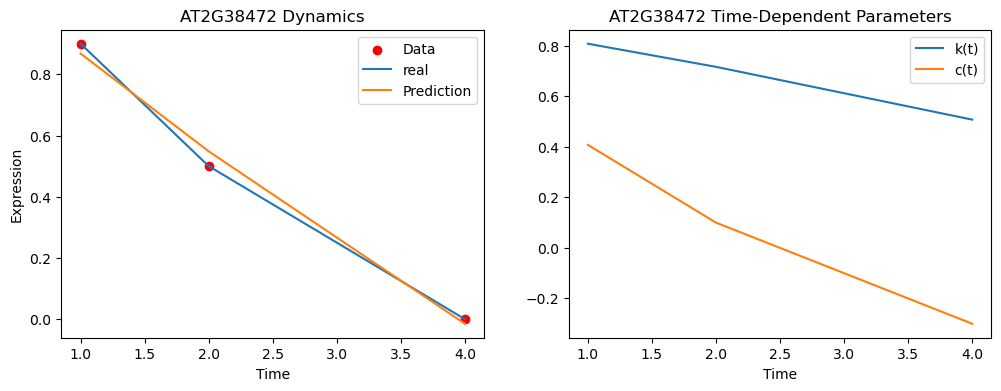

AT2G38473 - Epoch 0, Loss: 0.937823474407196
AT2G38473 - Epoch 100, Loss: 1.9947317923652008e-05
AT2G38473 - Epoch 200, Loss: 2.6987263481714763e-06


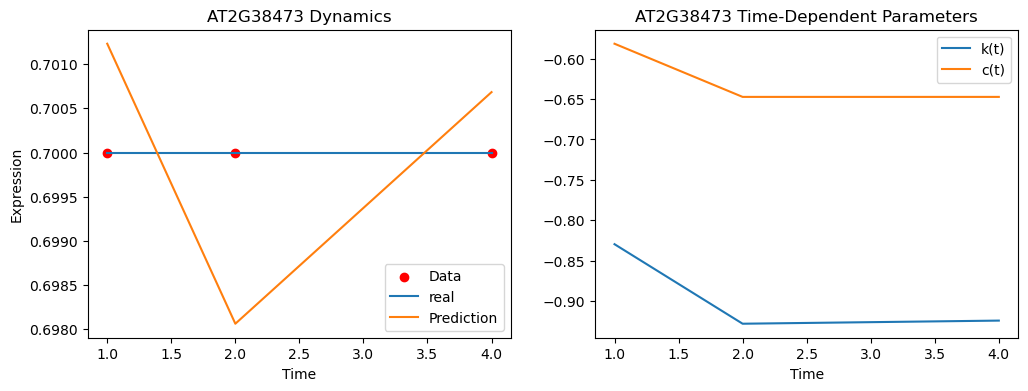

AT2G38474 - Epoch 0, Loss: 0.0721244215965271
AT2G38474 - Epoch 100, Loss: 0.050659116357564926
AT2G38474 - Epoch 200, Loss: 0.04256811738014221


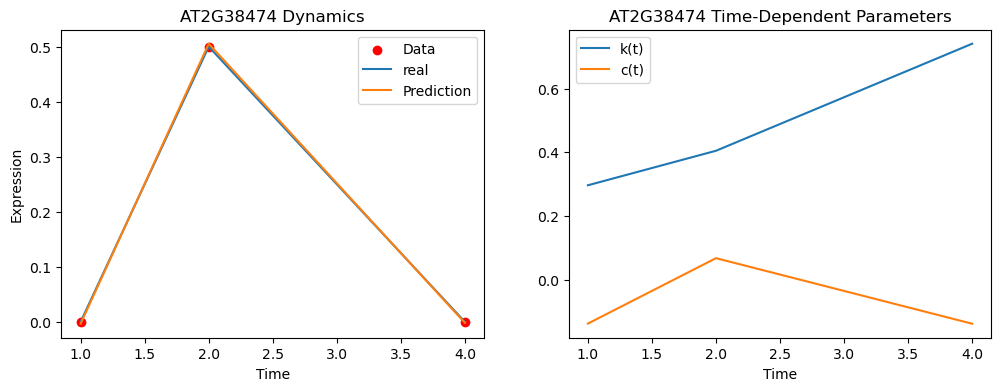

AT2G38470 - Epoch 0, Loss: 0.6862806081771851
AT2G38470 - Epoch 100, Loss: 1.3532760021917056e-05
AT2G38470 - Epoch 200, Loss: 1.7755302224031766e-06


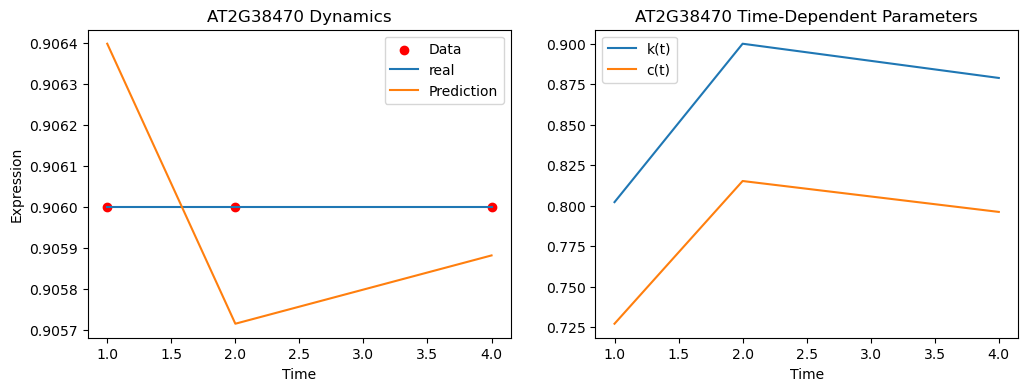


Example Learned Parameters (AT5G40100):
Time	k(t)		c(t)
1.00	-0.327211	-0.162987
1.03	-0.174866	-0.211610
1.06	0.000715	-0.313203


In [11]:
# Dataset
data = {
    "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    "AT1G06930": [1.778358524, 0, 0],
    "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

time_points = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)
results = {}

for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)
    
    # Initialize model and optimizer
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop
    for epoch in range(300):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item()}")
    
    # Save results
    # t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
    # y_pred, k_pred, c_pred = model(t_test)


    y_pred, k_pred, c_pred = model(time_points)

    
    results[gene] = {
        "y_pred": y_pred.detach().numpy(),
        "k(t)": k_pred.detach().numpy(),
        "c(t)": c_pred.detach().numpy()
    }

    # Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label='Data')
    plt.plot(time_points.detach().numpy(), y_data.numpy(), label='real')

    # plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), label='Prediction')
    plt.plot(time_points.detach().numpy(), y_pred.detach().numpy(), label='Prediction')

    plt.title(f"{gene} Dynamics")
    plt.xlabel("Time")
    plt.ylabel("Expression")
    plt.legend()

    plt.subplot(1, 2, 2)
    # plt.plot(t_test.detach().numpy(), k_pred.detach().numpy(), label='k(t)')
    # plt.plot(t_test.detach().numpy(), c_pred.detach().numpy(), label='c(t)')

    plt.plot(time_points.detach().numpy(), k_pred.detach().numpy(), label='k(t)')
    plt.plot(time_points.detach().numpy(), c_pred.detach().numpy(), label='c(t)')
    plt.title(f"{gene} Time-Dependent Parameters")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

# Print learned parameters (example for AT5G40100)
print("\nExample Learned Parameters (AT5G40100):")
print("Time\tk(t)\t\tc(t)")
for t, k, c in zip(t_test.detach().numpy(), 
                   results["AT5G40100"]["k(t)"], 
                   results["AT5G40100"]["c(t)"]):
    print(f"{t[0]:.2f}\t{k:.6f}\t{c:.6f}")

# INVERSE PINN 

    ode_residual = y_t + model.k * y_pred - model.c

AT5G40100 - Epoch 0, Loss: 10.052746772766113
AT5G40100 - Epoch 100, Loss: 0.03151002526283264
AT5G40100 - Epoch 200, Loss: 5.527404596250562e-07


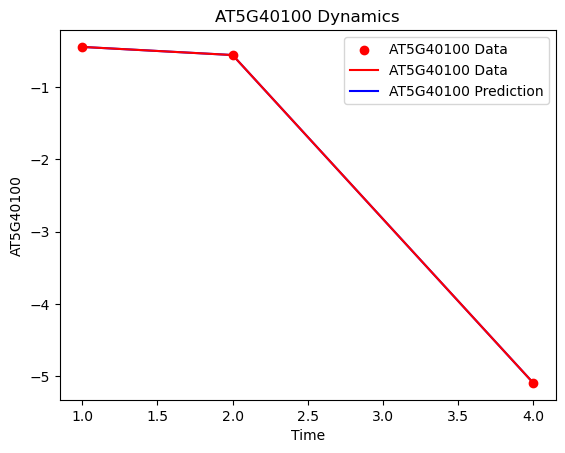

AT1G06930 - Epoch 0, Loss: 4.700829982757568
AT1G06930 - Epoch 100, Loss: 0.34164923429489136
AT1G06930 - Epoch 200, Loss: 0.009589022025465965


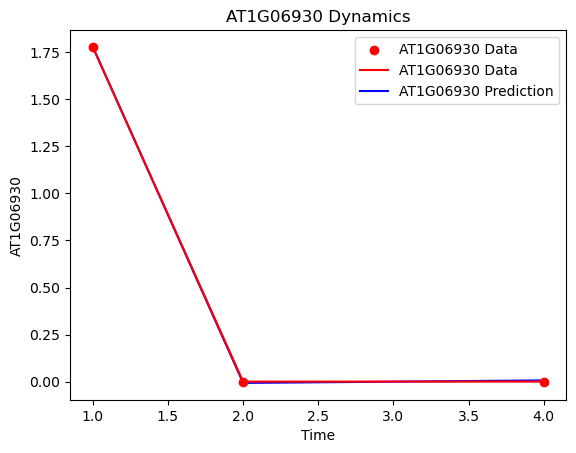

AT1G04470 - Epoch 0, Loss: 2.375140428543091
AT1G04470 - Epoch 100, Loss: 0.20677529275417328
AT1G04470 - Epoch 200, Loss: 0.0190199613571167


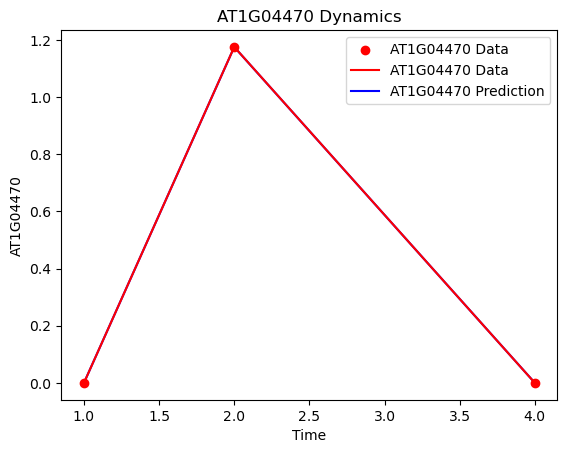

AT5G66730 - Epoch 0, Loss: 0.6248986721038818
AT5G66730 - Epoch 100, Loss: 0.05213100463151932
AT5G66730 - Epoch 200, Loss: 0.007938128896057606


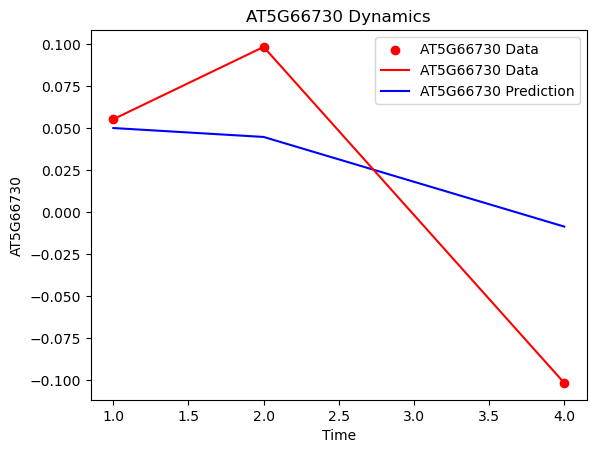

AT2G38471 - Epoch 0, Loss: 2.0949509143829346
AT2G38471 - Epoch 100, Loss: 0.001405444461852312
AT2G38471 - Epoch 200, Loss: 4.27118138759397e-05


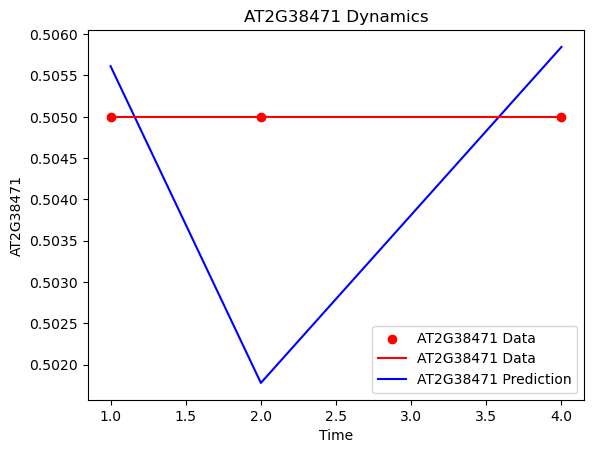

AT2G38472 - Epoch 0, Loss: 2.0097756385803223
AT2G38472 - Epoch 100, Loss: 0.11180244386196136
AT2G38472 - Epoch 200, Loss: 0.08495555818080902


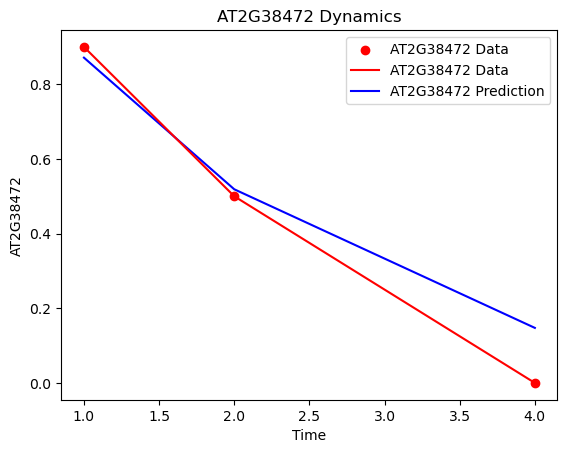

AT2G38473 - Epoch 0, Loss: 3.266108512878418
AT2G38473 - Epoch 100, Loss: 0.0002472461783327162
AT2G38473 - Epoch 200, Loss: 5.121547019371064e-06


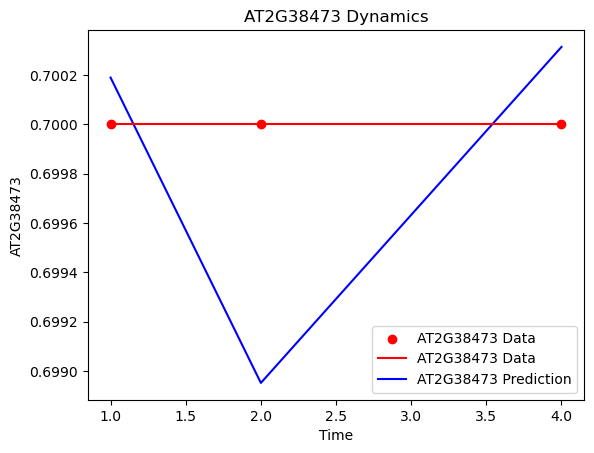

AT2G38474 - Epoch 0, Loss: 0.8318026065826416
AT2G38474 - Epoch 100, Loss: 0.07365987449884415
AT2G38474 - Epoch 200, Loss: 0.04290496185421944


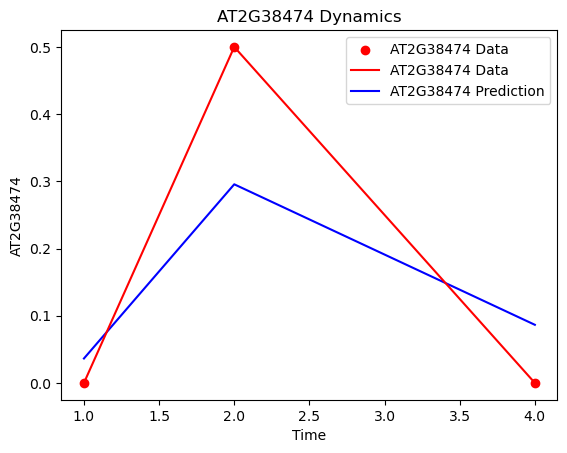

AT2G38470 - Epoch 0, Loss: 1.854132890701294
AT2G38470 - Epoch 100, Loss: 6.250560545595363e-05
AT2G38470 - Epoch 200, Loss: 1.5011372852313798e-05


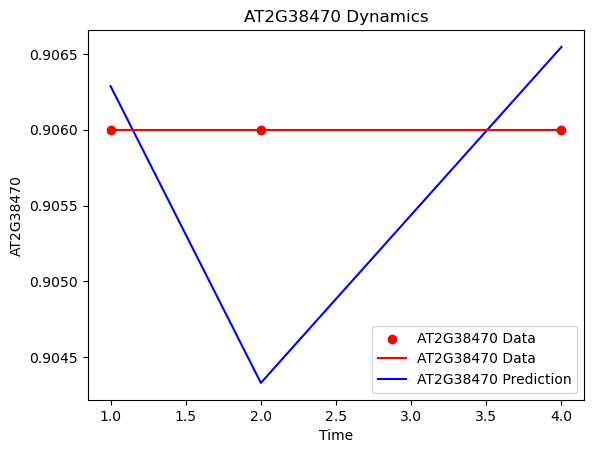

AT5G40100: k = -0.000002, c = 0.365790
AT1G06930: k = 0.006959, c = 0.023655
AT1G04470: k = 0.002592, c = 0.039623
AT5G66730: k = 1.382991, c = 0.033429
AT2G38471: k = 1.215201, c = 0.614414
AT2G38472: k = 0.525844, c = 0.128176
AT2G38473: k = 1.082227, c = 0.758463
AT2G38474: k = 1.100675, c = 0.138409
AT2G38470: k = 1.002367, c = 0.908995


In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 50),  # Input: time (t) and current value (y)
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Single output: dy/dt
        )
        # Trainable parameters (optional - remove if you want the NN to learn everything)
        self.k = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(1.0, requires_grad=True))  #Added C parameter

    def forward(self, t, y):
        # Concatenate time and current value for input
        input_tensor = torch.cat((t, y), dim=1)
        return self.hidden(input_tensor)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    #Initial guess for the value of y
    y_pred = model(t, torch.ones_like(t) * y_data[0]).squeeze()

    # Compute derivatives
    y_t = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

    #Initial conditions  
    initial_condition_loss = (y_pred[0] - y_data[0])**2
    
    # Predicted values based on NeuralODE
    ode_residual = y_t + model.k * y_pred - model.c

    # Physics loss
    physics_loss = torch.mean(ode_residual**2)

    # Data loss
    data_loss = torch.mean((y_pred - y_data)**2)

    return data_loss + 1.0 * physics_loss + initial_condition_loss

# Data: Replace with the given dataset
data = {
    "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    "AT1G06930": [1.778358524, 0, 0],
    "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

# Time points
time_points = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)

# Initialize results
results = {}

for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)

    # Initialize model and optimizer
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    for epoch in range(300):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item()}")

    # Save the learned parameters
    results[gene] = {
        "k": model.k.item(),
        "c": model.c.item()
    }

    # Generate predictions for plotting
    # t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
    
    # Need to provide the corresponding y values for the test times
    # y_test = model(t_test, torch.ones_like(t_test) * y_data[0]).detach().numpy()
    y_test = model(time_points, torch.ones_like(time_points) * y_data[0]).detach().numpy()

    # Plotting the results
    plt.figure()
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)
    plt.plot(time_points.detach().numpy(),  y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)

    plt.plot(time_points.detach().numpy(), y_test, label=f'{gene} Prediction', color='blue', zorder=4)

    # plt.plot(t_test.detach().numpy(), y_test, label=f'{gene} Prediction', color='blue', zorder=4)
    plt.title(f'{gene} Dynamics')
    plt.xlabel('Time')
    plt.ylabel(gene)
    plt.legend()
    plt.show()

# Print results
for gene, params in results.items():
    print(f"{gene}: k = {params['k']:.6f}, c = {params['c']:.6f}")


# inverse pinn    
    
    # Enforce that dy/dt equals the parametric ODE: α + β*y(t) + γ*t


AT5G40100 - Epoch 0, Loss: 25.7132
AT5G40100 - Epoch 100, Loss: 0.2850
AT5G40100 - Epoch 200, Loss: 0.0480


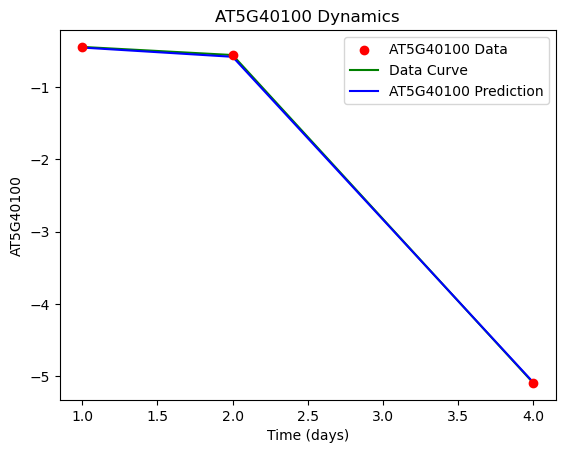

AT1G06930 - Epoch 0, Loss: 17.2140
AT1G06930 - Epoch 100, Loss: 0.3724
AT1G06930 - Epoch 200, Loss: 0.0098


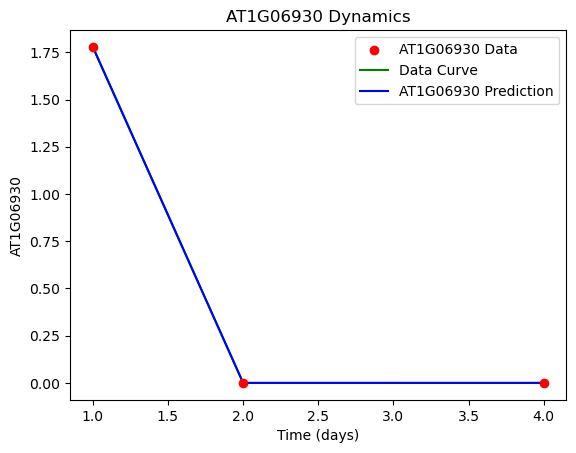

AT1G04470 - Epoch 0, Loss: 15.2237
AT1G04470 - Epoch 100, Loss: 0.7814
AT1G04470 - Epoch 200, Loss: 0.0001


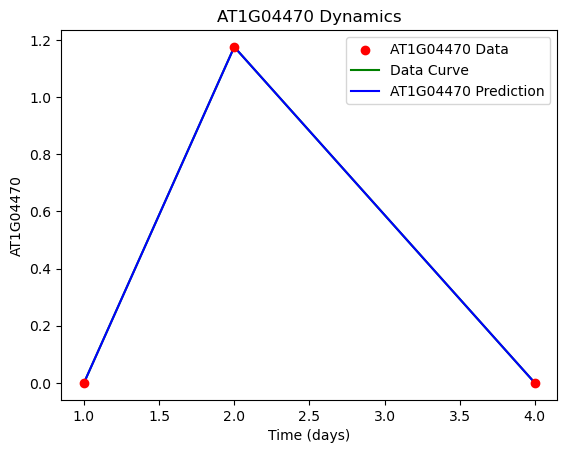

AT5G66730 - Epoch 0, Loss: 12.9452
AT5G66730 - Epoch 100, Loss: 0.4047
AT5G66730 - Epoch 200, Loss: 0.0494


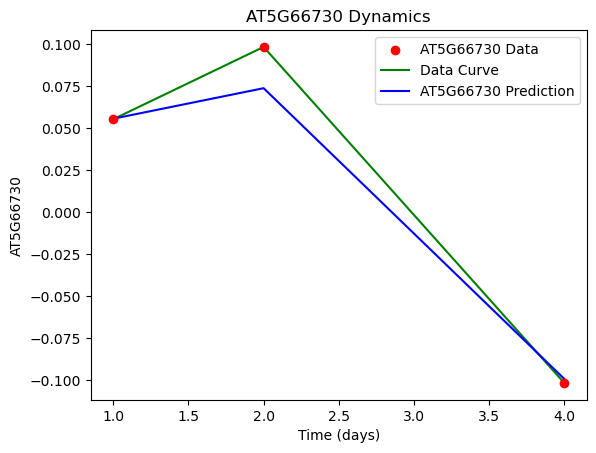

AT2G38471 - Epoch 0, Loss: 13.5810
AT2G38471 - Epoch 100, Loss: 0.8723
AT2G38471 - Epoch 200, Loss: 0.0305


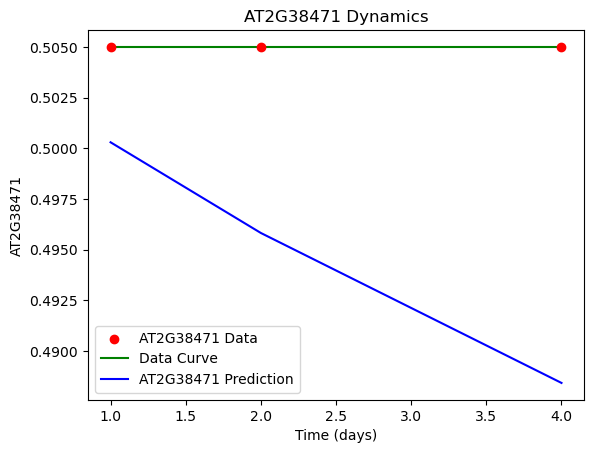

AT2G38472 - Epoch 0, Loss: 14.4664
AT2G38472 - Epoch 100, Loss: 0.7293
AT2G38472 - Epoch 200, Loss: 0.1315


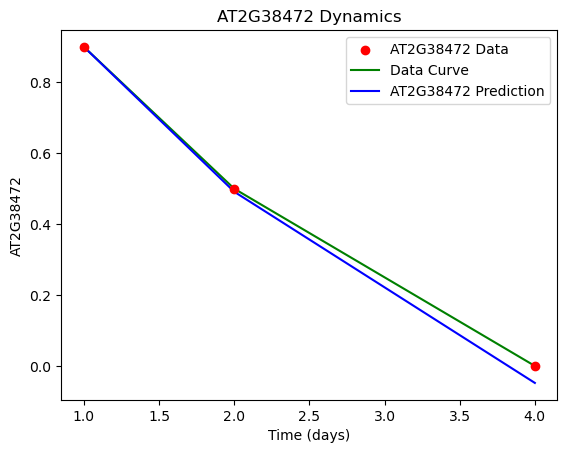

AT2G38473 - Epoch 0, Loss: 13.9367
AT2G38473 - Epoch 100, Loss: 0.3973
AT2G38473 - Epoch 200, Loss: 0.0012


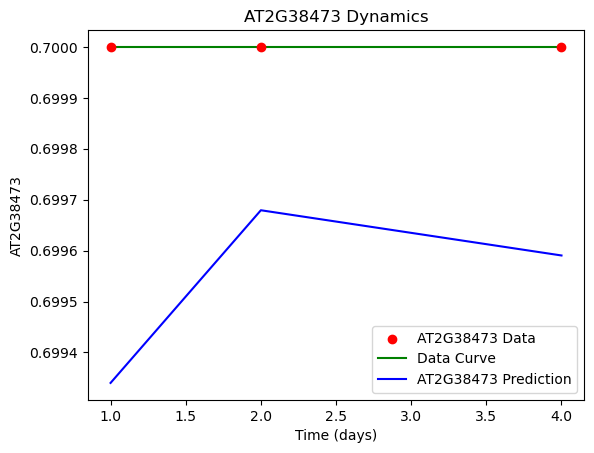

AT2G38474 - Epoch 0, Loss: 10.9307
AT2G38474 - Epoch 100, Loss: 0.6118
AT2G38474 - Epoch 200, Loss: 0.0005


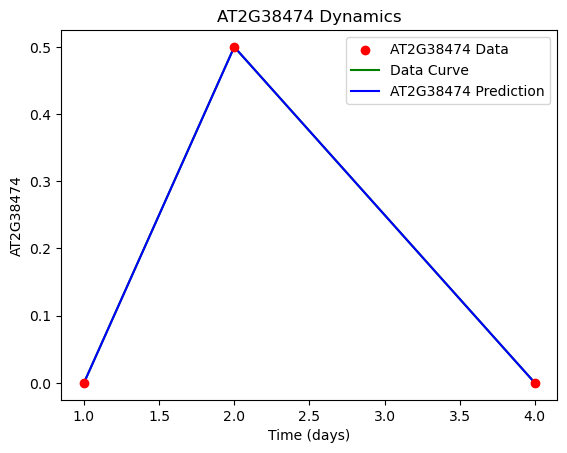

AT2G38470 - Epoch 0, Loss: 15.2315
AT2G38470 - Epoch 100, Loss: 1.0219
AT2G38470 - Epoch 200, Loss: 0.0014


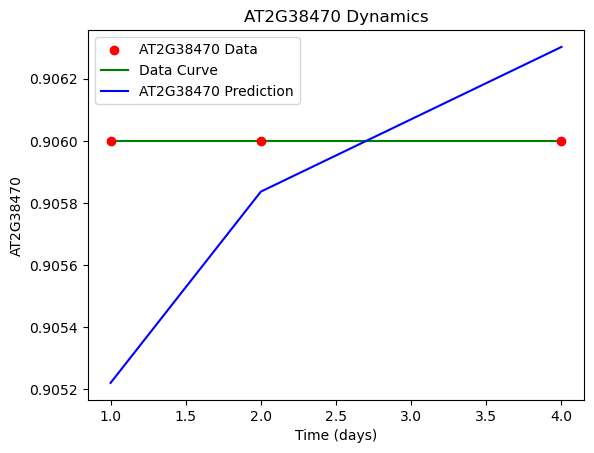

AT5G40100: alpha = 0.112740, beta = 1.516057, gamma = 0.359451
AT1G06930: alpha = 0.319285, beta = 1.604944, gamma = 0.267496
AT1G04470: alpha = 0.191624, beta = 1.546130, gamma = 0.206522
AT5G66730: alpha = 0.123097, beta = 1.664295, gamma = 0.093864
AT2G38471: alpha = 0.123063, beta = 1.595388, gamma = 0.032340
AT2G38472: alpha = 0.083827, beta = 1.686953, gamma = -0.010964
AT2G38473: alpha = 0.308304, beta = 1.521022, gamma = 0.273150
AT2G38474: alpha = 0.160442, beta = 1.658340, gamma = 0.125537
AT2G38470: alpha = 0.133498, beta = 1.489928, gamma = 0.122548


In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network that approximates y(t)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # Here we still model y(t) with a neural network
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: y(t)
        )
        # Learnable ODE parameters for: dy/dt = α + β*y(t) + γ*t
        self.alpha = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.beta  = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    # Predict y(t) using the neural network; shape: (num_time_points,)
    y_pred = model(t).squeeze()
    
    # Compute dy/dt via autograd
    y_t = torch.autograd.grad(
        y_pred, t, 
        grad_outputs=torch.ones_like(y_pred), 
        create_graph=True
    )[0].squeeze()
    
    # Enforce that dy/dt equals the parametric ODE: α + β*y(t) + γ*t
    # Note: squeeze t to match y_pred's shape.
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * t.squeeze())
    
    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)
    
    # Also enforce the initial condition (at the first time point)
    initial_condition_loss = (y_pred[0] - y_data[0])**2
    
    return data_loss + physics_loss + initial_condition_loss

# Data: Each gene has expression values at Day1, Day2, Day4
data = {
    "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    "AT1G06930": [1.778358524, 0, 0],
    "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

# Time points as a tensor: shape (3, 1)
time_points = torch.tensor([[1.0], [2.0], [4.0]], dtype=torch.float32, requires_grad=True)

results = {}

# Loop over each gene (each row of the dataset)
for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)
    
    # Initialize the neural network model for this gene
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop
    epochs = 300
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item():.4f}")
    
    # Save the learned parameters for this gene
    results[gene] = {
        "alpha": model.alpha.item(),
        "beta": model.beta.item(),
        "gamma": model.gamma.item()
    }
    
    # Generate predictions for plotting over a smooth time grid
    # t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1)
    # y_pred = model(t_test).detach().numpy()
    y_pred = model(time_points).detach().numpy()

    
    # Plot observed data vs. Neural ODE predictions
    plt.figure()
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)
    plt.plot(time_points.detach().numpy(), y_data.numpy(), color='green', label='Data Curve', zorder=3)
    # plt.plot(t_test.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)
    plt.plot(time_points.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)

    plt.title(f'{gene} Dynamics')
    plt.xlabel('Time (days)')
    plt.ylabel(gene)
    plt.legend()
    plt.show()

# Print the learned parameters for each gene
for gene, params in results.items():
    print(f"{gene}: alpha = {params['alpha']:.6f}, beta = {params['beta']:.6f}, gamma = {params['gamma']:.6f}")


# Inverse PINN


    # Compute the ODE residual:
    # dy/dt should equal α + β*y(t) + γ*(t - t0)
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * (t.squeeze() - t0))

AT5G40100 - Epoch 0, Loss: 11.4676
AT5G40100 - Epoch 100, Loss: 0.0611
AT5G40100 - Epoch 200, Loss: 0.0003
AT5G40100 - Epoch 300, Loss: 0.0000
AT5G40100 - Epoch 400, Loss: 0.0000
AT5G40100 - Epoch 500, Loss: 0.0000
AT5G40100 - Epoch 600, Loss: 0.0000
AT5G40100 - Epoch 700, Loss: 0.0000
AT5G40100 - Epoch 800, Loss: 0.0000
AT5G40100 - Epoch 900, Loss: 0.0000


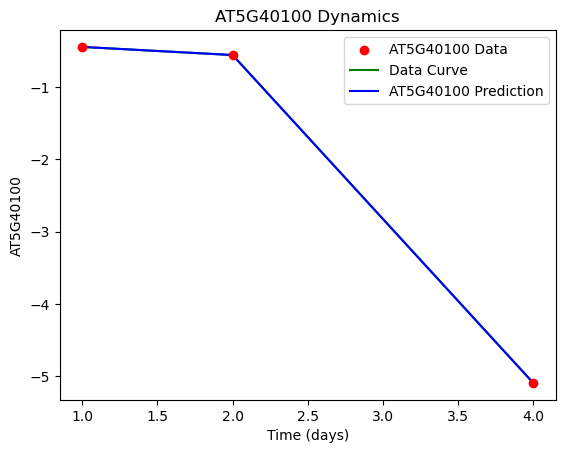

AT1G06930 - Epoch 0, Loss: 7.7146
AT1G06930 - Epoch 100, Loss: 0.1304
AT1G06930 - Epoch 200, Loss: 0.0088
AT1G06930 - Epoch 300, Loss: 0.0014
AT1G06930 - Epoch 400, Loss: 0.0008
AT1G06930 - Epoch 500, Loss: 0.0000
AT1G06930 - Epoch 600, Loss: 0.0000
AT1G06930 - Epoch 700, Loss: 0.0000
AT1G06930 - Epoch 800, Loss: 0.0000
AT1G06930 - Epoch 900, Loss: 0.0000


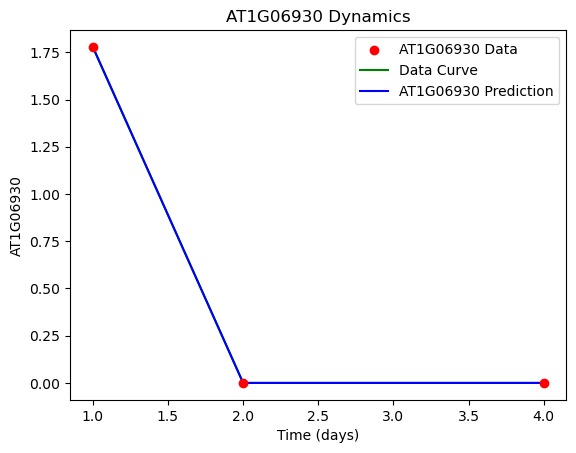

AT1G04470 - Epoch 0, Loss: 3.5805
AT1G04470 - Epoch 100, Loss: 0.0597
AT1G04470 - Epoch 200, Loss: 0.0000
AT1G04470 - Epoch 300, Loss: 0.0000
AT1G04470 - Epoch 400, Loss: 0.0000
AT1G04470 - Epoch 500, Loss: 0.0000
AT1G04470 - Epoch 600, Loss: 0.0000
AT1G04470 - Epoch 700, Loss: 0.0004
AT1G04470 - Epoch 800, Loss: 0.0000
AT1G04470 - Epoch 900, Loss: 0.0000


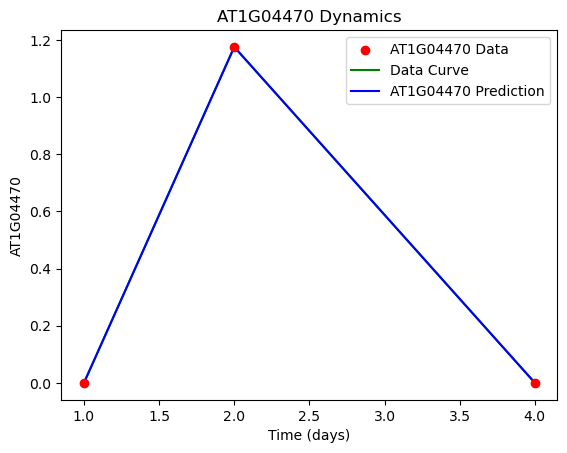

AT5G66730 - Epoch 0, Loss: 2.2148
AT5G66730 - Epoch 100, Loss: 0.0883
AT5G66730 - Epoch 200, Loss: 0.0072
AT5G66730 - Epoch 300, Loss: 0.0000
AT5G66730 - Epoch 400, Loss: 0.0000
AT5G66730 - Epoch 500, Loss: 0.0000
AT5G66730 - Epoch 600, Loss: 0.0000
AT5G66730 - Epoch 700, Loss: 0.0000
AT5G66730 - Epoch 800, Loss: 0.0000
AT5G66730 - Epoch 900, Loss: 0.0000


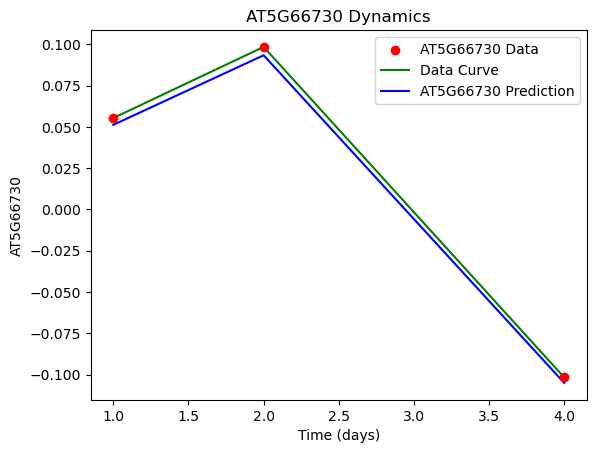

AT2G38471 - Epoch 0, Loss: 3.2245
AT2G38471 - Epoch 100, Loss: 0.3538
AT2G38471 - Epoch 200, Loss: 0.0396
AT2G38471 - Epoch 300, Loss: 0.0008
AT2G38471 - Epoch 400, Loss: 0.0000
AT2G38471 - Epoch 500, Loss: 0.0000
AT2G38471 - Epoch 600, Loss: 0.0042
AT2G38471 - Epoch 700, Loss: 0.0000
AT2G38471 - Epoch 800, Loss: 0.0000
AT2G38471 - Epoch 900, Loss: 0.0000


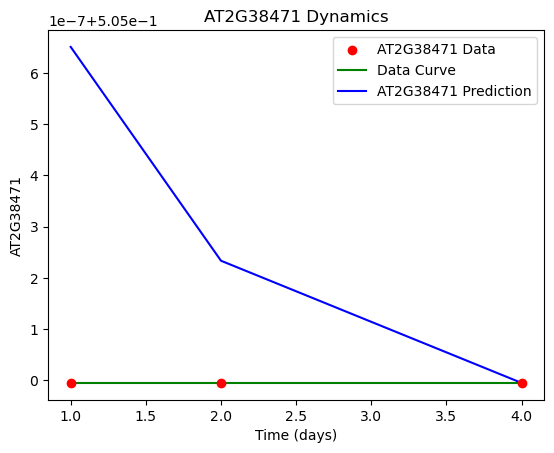

AT2G38472 - Epoch 0, Loss: 4.1150
AT2G38472 - Epoch 100, Loss: 0.2508
AT2G38472 - Epoch 200, Loss: 0.0457
AT2G38472 - Epoch 300, Loss: 0.0006
AT2G38472 - Epoch 400, Loss: 0.0000
AT2G38472 - Epoch 500, Loss: 0.0000
AT2G38472 - Epoch 600, Loss: 0.0000
AT2G38472 - Epoch 700, Loss: 0.0000
AT2G38472 - Epoch 800, Loss: 0.0000
AT2G38472 - Epoch 900, Loss: 0.0003


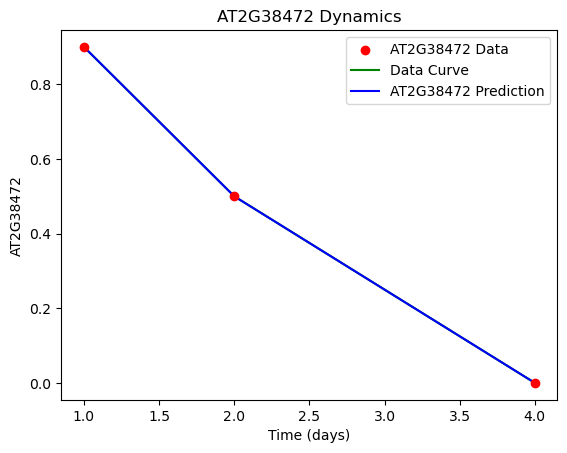

AT2G38473 - Epoch 0, Loss: 3.8737
AT2G38473 - Epoch 100, Loss: 0.1972
AT2G38473 - Epoch 200, Loss: 0.0014
AT2G38473 - Epoch 300, Loss: 0.0004
AT2G38473 - Epoch 400, Loss: 0.0001
AT2G38473 - Epoch 500, Loss: 0.0000
AT2G38473 - Epoch 600, Loss: 0.0000
AT2G38473 - Epoch 700, Loss: 0.0048
AT2G38473 - Epoch 800, Loss: 0.0000
AT2G38473 - Epoch 900, Loss: 0.0001


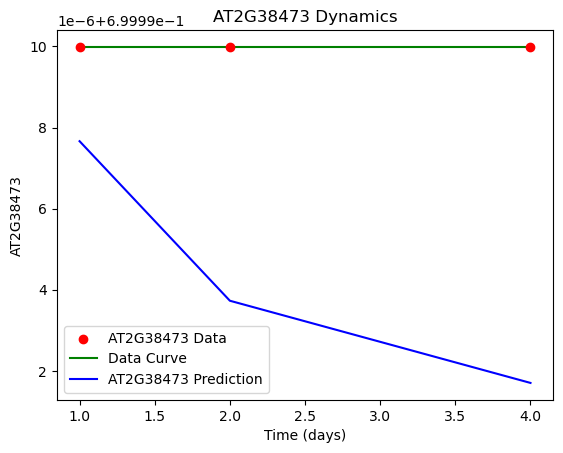

AT2G38474 - Epoch 0, Loss: 2.5563
AT2G38474 - Epoch 100, Loss: 0.2017
AT2G38474 - Epoch 200, Loss: 0.0018
AT2G38474 - Epoch 300, Loss: 0.0000
AT2G38474 - Epoch 400, Loss: 0.0000
AT2G38474 - Epoch 500, Loss: 0.0000
AT2G38474 - Epoch 600, Loss: 0.0000
AT2G38474 - Epoch 700, Loss: 0.0000
AT2G38474 - Epoch 800, Loss: 0.0000
AT2G38474 - Epoch 900, Loss: 0.0000


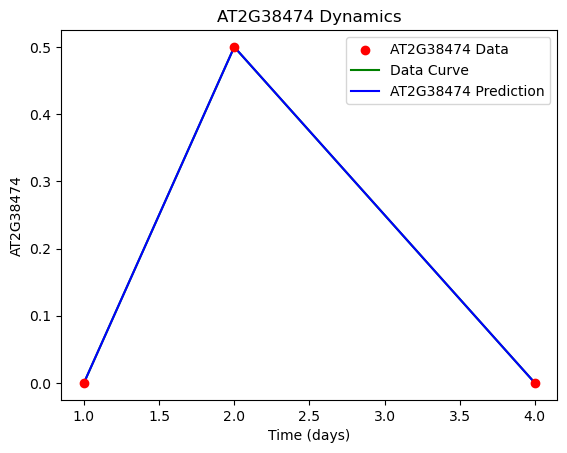

AT2G38470 - Epoch 0, Loss: 4.2897
AT2G38470 - Epoch 100, Loss: 0.1602
AT2G38470 - Epoch 200, Loss: 0.0000
AT2G38470 - Epoch 300, Loss: 0.0001
AT2G38470 - Epoch 400, Loss: 0.0000
AT2G38470 - Epoch 500, Loss: 0.0000
AT2G38470 - Epoch 600, Loss: 0.0000
AT2G38470 - Epoch 700, Loss: 0.0000
AT2G38470 - Epoch 800, Loss: 0.0000
AT2G38470 - Epoch 900, Loss: 0.0025


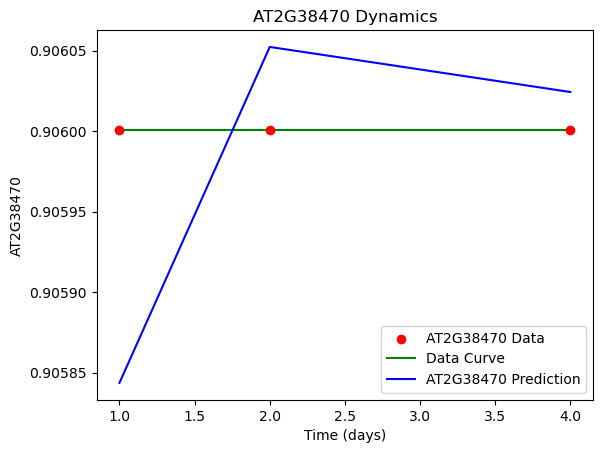

AT5G40100: alpha = 0.872972, beta = 0.956407, gamma = 0.940599
AT1G06930: alpha = 0.123124, beta = 1.450757, gamma = -0.065496
AT1G04470: alpha = 0.263439, beta = 1.579390, gamma = 0.212122
AT5G66730: alpha = 0.025756, beta = 1.719236, gamma = 0.144708
AT2G38471: alpha = -0.213872, beta = 1.176155, gamma = -0.032467
AT2G38472: alpha = -0.037305, beta = 1.557610, gamma = 0.118416
AT2G38473: alpha = 0.122398, beta = 1.049204, gamma = 0.212365
AT2G38474: alpha = 0.046065, beta = 1.709472, gamma = 0.038393
AT2G38470: alpha = 0.119745, beta = 0.282835, gamma = 0.114828


In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network that approximates y(t)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Approximates y(t)
        )
        # Learnable ODE parameters for: dy/dt = α + β*y(t) + γ*(t - t0)
        self.alpha = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.beta  = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Calculate the mean of the time points (t0)
t0_value = np.mean([1.0, 2.0, 4.0])
t0 = torch.tensor(t0_value, dtype=torch.float32)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    # Predict y(t); shape: (num_time_points,)
    y_pred = model(t).squeeze()
    
    # Compute derivative dy/dt via autograd
    y_t = torch.autograd.grad(
        y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True
    )[0].squeeze()
    
    # Compute the ODE residual:
    # dy/dt should equal α + β*y(t) + γ*(t - t0)
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * (t.squeeze() - t0))
    
    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)
    
    # Enforce the initial condition explicitly
    initial_condition_loss = (y_pred[0] - y_data[0])**2
    
    return data_loss + physics_loss + initial_condition_loss

# Data: Each gene has expression values at Day1, Day2, Day4
data = {
    "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    "AT1G06930": [1.778358524, 0, 0],
    "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

# Time points as a tensor: shape (3, 1)
time_points = torch.tensor([[1.0], [2.0], [4.0]], dtype=torch.float32, requires_grad=True)

results = {}

# Loop over each gene (each row is a time series for one gene)
for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)
    
    # Initialize the model and optimizer for this gene
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop
    epochs = 1000
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item():.4f}")
    
    # Save learned parameters
    results[gene] = {
        "alpha": model.alpha.item(),
        "beta": model.beta.item(),
        "gamma": model.gamma.item()
    }
    
    # Generate predictions over a smooth time grid for plotting
    # t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1)
    # y_pred = model(t_test).detach().numpy()
    y_pred = model(time_points).detach().numpy()


    
    # Plot observed data vs. Neural ODE predictions
    plt.figure()
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)
    plt.plot(time_points.detach().numpy(), y_data.numpy(), color='green', label='Data Curve', zorder=3)
    # plt.plot(t_test.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)
    plt.plot(time_points.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)

    plt.title(f'{gene} Dynamics')
    plt.xlabel('Time (days)')
    plt.ylabel(gene)
    plt.legend()
    plt.show()

# Print learned parameters for each gene
for gene, params in results.items():
    print(f"{gene}: alpha = {params['alpha']:.6f}, beta = {params['beta']:.6f}, gamma = {params['gamma']:.6f}")


# INVERSE PINN

    # Compute the ODE residual:
    # dy/dt should equal α + β*y(t) + γ*(t - t0)
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * (t.squeeze() - t0))

AT5G66730 - Epoch 0, Loss: 2.3796
AT5G66730 - Epoch 100, Loss: 0.0924
AT5G66730 - Epoch 200, Loss: 0.0092
AT5G66730 - Epoch 300, Loss: 0.0020
AT5G66730 - Epoch 400, Loss: 0.0003
AT5G66730 - Epoch 500, Loss: 0.0000
AT5G66730 - Epoch 600, Loss: 0.0000
AT5G66730 - Epoch 700, Loss: 0.0000
AT5G66730 - Epoch 800, Loss: 0.0000
AT5G66730 - Epoch 900, Loss: 0.0000
AT5G66730 - Epoch 1000, Loss: 0.0000
AT5G66730 - Epoch 1100, Loss: 0.0000
AT5G66730 - Epoch 1200, Loss: 0.0000
AT5G66730 - Epoch 1300, Loss: 0.0000
AT5G66730 - Epoch 1400, Loss: 0.0002
AT5G66730 - Epoch 1500, Loss: 0.0000
AT5G66730 - Epoch 1600, Loss: 0.0000
AT5G66730 - Epoch 1700, Loss: 0.0000
AT5G66730 - Epoch 1800, Loss: 0.0000
AT5G66730 - Epoch 1900, Loss: 0.0000
AT5G66730 - Epoch 2000, Loss: 0.0000
AT5G66730 - Epoch 2100, Loss: 0.0000
AT5G66730 - Epoch 2200, Loss: 0.0001
AT5G66730 - Epoch 2300, Loss: 0.0000
AT5G66730 - Epoch 2400, Loss: 0.0000
AT5G66730 - Epoch 2500, Loss: 0.0000
AT5G66730 - Epoch 2600, Loss: 0.0000
AT5G66730 - E

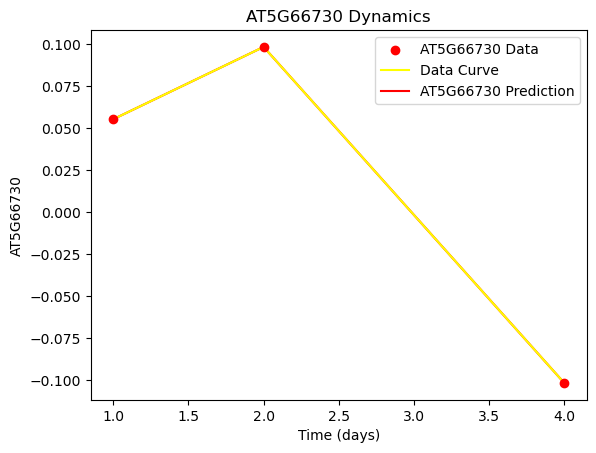

AT2G38471 - Epoch 0, Loss: 2.9463
AT2G38471 - Epoch 100, Loss: 0.4482
AT2G38471 - Epoch 200, Loss: 0.0384
AT2G38471 - Epoch 300, Loss: 0.0025
AT2G38471 - Epoch 400, Loss: 0.0000
AT2G38471 - Epoch 500, Loss: 0.0000
AT2G38471 - Epoch 600, Loss: 0.0000
AT2G38471 - Epoch 700, Loss: 0.0000
AT2G38471 - Epoch 800, Loss: 0.0000
AT2G38471 - Epoch 900, Loss: 0.0000
AT2G38471 - Epoch 1000, Loss: 0.0000
AT2G38471 - Epoch 1100, Loss: 0.0000
AT2G38471 - Epoch 1200, Loss: 0.0000
AT2G38471 - Epoch 1300, Loss: 0.0000
AT2G38471 - Epoch 1400, Loss: 0.0000
AT2G38471 - Epoch 1500, Loss: 0.0000
AT2G38471 - Epoch 1600, Loss: 0.0044
AT2G38471 - Epoch 1700, Loss: 0.0000
AT2G38471 - Epoch 1800, Loss: 0.0000
AT2G38471 - Epoch 1900, Loss: 0.0000
AT2G38471 - Epoch 2000, Loss: 0.0000
AT2G38471 - Epoch 2100, Loss: 0.0000
AT2G38471 - Epoch 2200, Loss: 0.0000
AT2G38471 - Epoch 2300, Loss: 0.0000
AT2G38471 - Epoch 2400, Loss: 0.0000
AT2G38471 - Epoch 2500, Loss: 0.0000
AT2G38471 - Epoch 2600, Loss: 0.0000
AT2G38471 - E

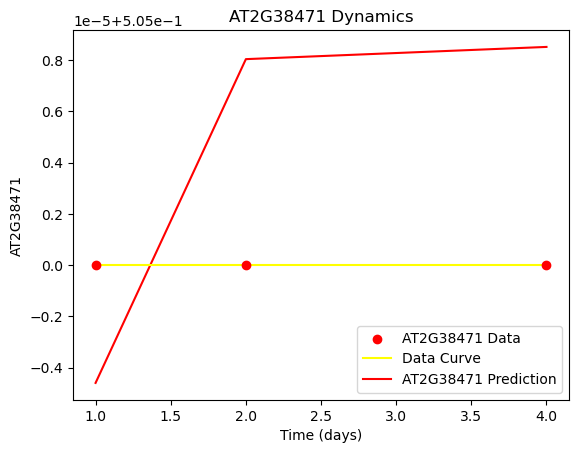

AT2G38473 - Epoch 0, Loss: 4.4507
AT2G38473 - Epoch 100, Loss: 0.3691
AT2G38473 - Epoch 200, Loss: 0.0002
AT2G38473 - Epoch 300, Loss: 0.0000
AT2G38473 - Epoch 400, Loss: 0.0000
AT2G38473 - Epoch 500, Loss: 0.0000
AT2G38473 - Epoch 600, Loss: 0.0000
AT2G38473 - Epoch 700, Loss: 0.0000
AT2G38473 - Epoch 800, Loss: 0.0001
AT2G38473 - Epoch 900, Loss: 0.0000
AT2G38473 - Epoch 1000, Loss: 0.0000
AT2G38473 - Epoch 1100, Loss: 0.0003
AT2G38473 - Epoch 1200, Loss: 0.0000
AT2G38473 - Epoch 1300, Loss: 0.0000
AT2G38473 - Epoch 1400, Loss: 0.0000
AT2G38473 - Epoch 1500, Loss: 0.0000
AT2G38473 - Epoch 1600, Loss: 0.0000
AT2G38473 - Epoch 1700, Loss: 0.0000
AT2G38473 - Epoch 1800, Loss: 0.0000
AT2G38473 - Epoch 1900, Loss: 0.0000
AT2G38473 - Epoch 2000, Loss: 0.0000
AT2G38473 - Epoch 2100, Loss: 0.0000
AT2G38473 - Epoch 2200, Loss: 0.0000
AT2G38473 - Epoch 2300, Loss: 0.0000
AT2G38473 - Epoch 2400, Loss: 0.0000
AT2G38473 - Epoch 2500, Loss: 0.0000
AT2G38473 - Epoch 2600, Loss: 0.0000
AT2G38473 - E

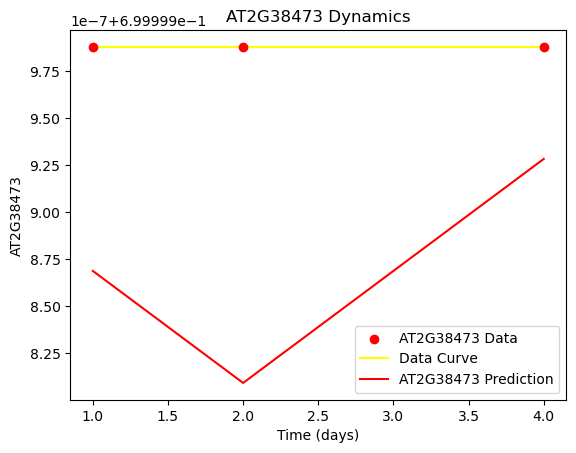

AT2G38470 - Epoch 0, Loss: 4.9440
AT2G38470 - Epoch 100, Loss: 0.1027
AT2G38470 - Epoch 200, Loss: 0.0004
AT2G38470 - Epoch 300, Loss: 0.0003
AT2G38470 - Epoch 400, Loss: 0.0004
AT2G38470 - Epoch 500, Loss: 0.0000
AT2G38470 - Epoch 600, Loss: 0.0000
AT2G38470 - Epoch 700, Loss: 0.0000
AT2G38470 - Epoch 800, Loss: 0.0000
AT2G38470 - Epoch 900, Loss: 0.0000
AT2G38470 - Epoch 1000, Loss: 0.0000
AT2G38470 - Epoch 1100, Loss: 0.0000
AT2G38470 - Epoch 1200, Loss: 0.0000
AT2G38470 - Epoch 1300, Loss: 0.0000
AT2G38470 - Epoch 1400, Loss: 0.0000
AT2G38470 - Epoch 1500, Loss: 0.0000
AT2G38470 - Epoch 1600, Loss: 0.0006
AT2G38470 - Epoch 1700, Loss: 0.0000
AT2G38470 - Epoch 1800, Loss: 0.0000
AT2G38470 - Epoch 1900, Loss: 0.0000
AT2G38470 - Epoch 2000, Loss: 0.0000
AT2G38470 - Epoch 2100, Loss: 0.0000
AT2G38470 - Epoch 2200, Loss: 0.0000
AT2G38470 - Epoch 2300, Loss: 0.0003
AT2G38470 - Epoch 2400, Loss: 0.0000
AT2G38470 - Epoch 2500, Loss: 0.0000
AT2G38470 - Epoch 2600, Loss: 0.0000
AT2G38470 - E

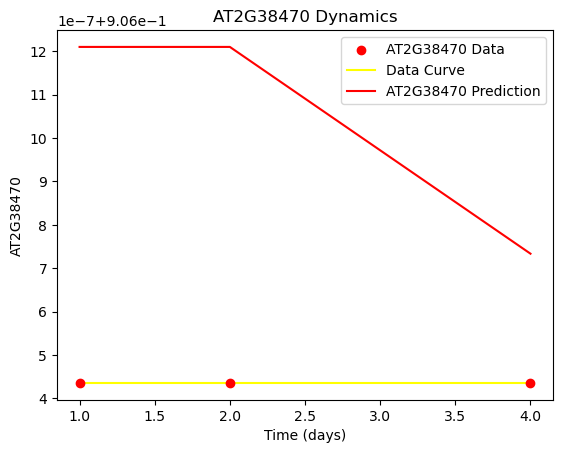

AT5G66730: alpha = 0.011871, beta = 1.506187, gamma = 0.075859
AT2G38471: alpha = -0.398005, beta = 0.806494, gamma = -0.006974
AT2G38473: alpha = -0.154487, beta = 0.181569, gamma = 0.003686
AT2G38470: alpha = 0.051242, beta = -0.055033, gamma = 0.001685


In [23]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network that approximates y(t)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Approximates y(t)
        )
        # Learnable ODE parameters for: dy/dt = α + β*y(t) + γ*(t - t0)
        self.alpha = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.beta  = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Calculate the mean of the time points (t0)
t0_value = np.mean([1.0, 2.0, 4.0])
t0 = torch.tensor(t0_value, dtype=torch.float32)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    # Predict y(t); shape: (num_time_points,)
    y_pred = model(t).squeeze()
    
    # Compute derivative dy/dt via autograd
    y_t = torch.autograd.grad(
        y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True
    )[0].squeeze()
    
    # Compute the ODE residual:
    # dy/dt should equal α + β*y(t) + γ*(t - t0)
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * (t.squeeze() - t0))
    
    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)
    
    # Enforce the initial condition explicitly
    initial_condition_loss = (y_pred[0] - y_data[0])**2
    
    return data_loss + physics_loss + initial_condition_loss

# Data: Each gene has expression values at Day1, Day2, Day4
data = {
    # "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    # "AT1G06930": [1.778358524, 0, 0],
    # "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    # "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    # "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

# Time points as a tensor: shape (3, 1)
time_points = torch.tensor([[1.0], [2.0], [4.0]], dtype=torch.float32, requires_grad=True)

results = {}

# Loop over each gene (each row is a time series for one gene)
for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)
    
    # Initialize the model and optimizer for this gene
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop
    epochs = 10000
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item():.4f}")
    
    # Save learned parameters
    results[gene] = {
        "alpha": model.alpha.item(),
        "beta": model.beta.item(),
        "gamma": model.gamma.item()
    }
    
    # Generate predictions over a smooth time grid for plotting
    # t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1)
    # y_pred = model(t_test).detach().numpy()
    y_pred = model(time_points).detach().numpy()


    
    # Plot observed data vs. Neural ODE predictions
    plt.figure()
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)
    plt.plot(time_points.detach().numpy(), y_data.numpy(), color='yellow', label='Data Curve', zorder=4)
    # plt.plot(t_test.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)

    plt.plot(time_points.detach().numpy(), y_pred, 'r-', label=f'{gene} Prediction', zorder=3)


    plt.title(f'{gene} Dynamics')
    plt.xlabel('Time (days)')
    plt.ylabel(gene)
    plt.legend()
    plt.show()

# Print learned parameters for each gene
for gene, params in results.items():
    print(f"{gene}: alpha = {params['alpha']:.6f}, beta = {params['beta']:.6f}, gamma = {params['gamma']:.6f}")
